In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_e_k5_b25_t1t2_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(4629816, 92)
(4629816, 8)
validation
(621056, 92)
(621056, 8)
test
(624904, 92)
(624904, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 92)]              0         


 dense (Dense)               (None, 1024)              95232     


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 785288 (3.00 MB)


Trainable params: 785288 (3.00 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/463 [..............................] - ETA: 9:50 - loss: 2.2729 - STD: 0.0831 - MAE: 0.2167

  8/463 [..............................] - ETA: 3s - loss: 2.1070 - STD: 0.0482 - MAE: 0.2166  

 15/463 [..............................] - ETA: 3s - loss: 2.0854 - STD: 0.0423 - MAE: 0.2167

 22/463 [>.............................] - ETA: 3s - loss: 2.0762 - STD: 0.0406 - MAE: 0.2166

 29/463 [>.............................] - ETA: 3s - loss: 2.0705 - STD: 0.0386 - MAE: 0.2166

 36/463 [=>............................] - ETA: 3s - loss: 2.0670 - STD: 0.0374 - MAE: 0.2166

 43/463 [=>............................] - ETA: 3s - loss: 2.0645 - STD: 0.0366 - MAE: 0.2167

 50/463 [==>...........................] - ETA: 3s - loss: 2.0623 - STD: 0.0361 - MAE: 0.2166

 57/463 [==>...........................] - ETA: 3s - loss: 2.0609 - STD: 0.0355 - MAE: 0.2166

 64/463 [===>..........................] - ETA: 3s - loss: 2.0596 - STD: 0.0351 - MAE: 0.2166

 71/463 [===>..........................] - ETA: 3s - loss: 2.0582 - STD: 0.0347 - MAE: 0.2166

 76/463 [===>..........................] - ETA: 6s - loss: 2.0569 - STD: 0.0346 - MAE: 0.2166

 83/463 [====>.........................] - ETA: 6s - loss: 2.0545 - STD: 0.0346 - MAE: 0.2165

 90/463 [====>.........................] - ETA: 6s - loss: 2.0512 - STD: 0.0350 - MAE: 0.2164

 97/463 [=====>........................] - ETA: 5s - loss: 2.0468 - STD: 0.0360 - MAE: 0.2162

104/463 [=====>........................] - ETA: 5s - loss: 2.0412 - STD: 0.0371 - MAE: 0.2159

111/463 [======>.......................] - ETA: 5s - loss: 2.0345 - STD: 0.0385 - MAE: 0.2156

118/463 [======>.......................] - ETA: 4s - loss: 2.0272 - STD: 0.0400 - MAE: 0.2152

125/463 [=======>......................] - ETA: 4s - loss: 2.0200 - STD: 0.0418 - MAE: 0.2148

132/463 [=======>......................] - ETA: 4s - loss: 2.0131 - STD: 0.0436 - MAE: 0.2144

139/463 [========>.....................] - ETA: 4s - loss: 2.0065 - STD: 0.0453 - MAE: 0.2140

146/463 [========>.....................] - ETA: 4s - loss: 2.0008 - STD: 0.0468 - MAE: 0.2137

153/463 [========>.....................] - ETA: 3s - loss: 1.9952 - STD: 0.0482 - MAE: 0.2133

160/463 [=========>....................] - ETA: 3s - loss: 1.9899 - STD: 0.0496 - MAE: 0.2130

167/463 [=========>....................] - ETA: 3s - loss: 1.9850 - STD: 0.0508 - MAE: 0.2127

174/463 [==========>...................] - ETA: 3s - loss: 1.9805 - STD: 0.0520 - MAE: 0.2124

181/463 [==========>...................] - ETA: 3s - loss: 1.9760 - STD: 0.0530 - MAE: 0.2122

188/463 [===========>..................] - ETA: 3s - loss: 1.9719 - STD: 0.0541 - MAE: 0.2119

195/463 [===========>..................] - ETA: 3s - loss: 1.9679 - STD: 0.0551 - MAE: 0.2116

202/463 [============>.................] - ETA: 3s - loss: 1.9642 - STD: 0.0561 - MAE: 0.2114

209/463 [============>.................] - ETA: 2s - loss: 1.9606 - STD: 0.0570 - MAE: 0.2112

216/463 [============>.................] - ETA: 2s - loss: 1.9573 - STD: 0.0579 - MAE: 0.2110

223/463 [=============>................] - ETA: 2s - loss: 1.9540 - STD: 0.0588 - MAE: 0.2107

230/463 [=============>................] - ETA: 2s - loss: 1.9509 - STD: 0.0596 - MAE: 0.2105

237/463 [==============>...............] - ETA: 2s - loss: 1.9478 - STD: 0.0603 - MAE: 0.2103

244/463 [==============>...............] - ETA: 2s - loss: 1.9449 - STD: 0.0611 - MAE: 0.2101

251/463 [===============>..............] - ETA: 2s - loss: 1.9421 - STD: 0.0618 - MAE: 0.2100

258/463 [===============>..............] - ETA: 2s - loss: 1.9393 - STD: 0.0625 - MAE: 0.2098

265/463 [================>.............] - ETA: 2s - loss: 1.9363 - STD: 0.0632 - MAE: 0.2096

272/463 [================>.............] - ETA: 2s - loss: 1.9335 - STD: 0.0639 - MAE: 0.2094

279/463 [=================>............] - ETA: 1s - loss: 1.9307 - STD: 0.0645 - MAE: 0.2092

286/463 [=================>............] - ETA: 1s - loss: 1.9281 - STD: 0.0652 - MAE: 0.2090

293/463 [=================>............] - ETA: 1s - loss: 1.9254 - STD: 0.0659 - MAE: 0.2088

300/463 [==================>...........] - ETA: 1s - loss: 1.9228 - STD: 0.0665 - MAE: 0.2086

307/463 [==================>...........] - ETA: 1s - loss: 1.9202 - STD: 0.0672 - MAE: 0.2085

313/463 [===================>..........] - ETA: 1s - loss: 1.9180 - STD: 0.0677 - MAE: 0.2083

320/463 [===================>..........] - ETA: 1s - loss: 1.9155 - STD: 0.0683 - MAE: 0.2081

327/463 [====================>.........] - ETA: 1s - loss: 1.9131 - STD: 0.0689 - MAE: 0.2080

334/463 [====================>.........] - ETA: 1s - loss: 1.9108 - STD: 0.0694 - MAE: 0.2078

341/463 [=====================>........] - ETA: 1s - loss: 1.9085 - STD: 0.0700 - MAE: 0.2077

348/463 [=====================>........] - ETA: 1s - loss: 1.9063 - STD: 0.0705 - MAE: 0.2075

355/463 [======================>.......] - ETA: 1s - loss: 1.9041 - STD: 0.0710 - MAE: 0.2074

362/463 [======================>.......] - ETA: 1s - loss: 1.9020 - STD: 0.0715 - MAE: 0.2072

369/463 [======================>.......] - ETA: 0s - loss: 1.9000 - STD: 0.0720 - MAE: 0.2071

376/463 [=======================>......] - ETA: 0s - loss: 1.8981 - STD: 0.0725 - MAE: 0.2069

383/463 [=======================>......] - ETA: 0s - loss: 1.8962 - STD: 0.0729 - MAE: 0.2068

390/463 [========================>.....] - ETA: 0s - loss: 1.8943 - STD: 0.0733 - MAE: 0.2067

397/463 [========================>.....] - ETA: 0s - loss: 1.8925 - STD: 0.0737 - MAE: 0.2066

404/463 [=========================>....] - ETA: 0s - loss: 1.8907 - STD: 0.0741 - MAE: 0.2064

411/463 [=========================>....] - ETA: 0s - loss: 1.8889 - STD: 0.0745 - MAE: 0.2063

413/463 [=========================>....] - ETA: 0s - loss: 1.8885 - STD: 0.0746 - MAE: 0.2063

420/463 [==========================>...] - ETA: 0s - loss: 1.8868 - STD: 0.0750 - MAE: 0.2062

427/463 [==========================>...] - ETA: 0s - loss: 1.8851 - STD: 0.0754 - MAE: 0.2061

434/463 [===========================>..] - ETA: 0s - loss: 1.8835 - STD: 0.0758 - MAE: 0.2060

441/463 [===========================>..] - ETA: 0s - loss: 1.8820 - STD: 0.0761 - MAE: 0.2059

448/463 [============================>.] - ETA: 0s - loss: 1.8805 - STD: 0.0765 - MAE: 0.2057

455/463 [============================>.] - ETA: 0s - loss: 1.8790 - STD: 0.0768 - MAE: 0.2056

462/463 [============================>.] - ETA: 0s - loss: 1.8774 - STD: 0.0771 - MAE: 0.2055

463/463 [==============================] - 6s 11ms/step - loss: 1.8772 - STD: 0.0772 - MAE: 0.2055 - val_loss: 1.7592 - val_STD: 0.0887 - val_MAE: 0.1997


Epoch 2/10000


  1/463 [..............................] - ETA: 11s - loss: 1.7779 - STD: 0.0992 - MAE: 0.1987

  8/463 [..............................] - ETA: 3s - loss: 1.7822 - STD: 0.0981 - MAE: 0.1992 

 15/463 [..............................] - ETA: 3s - loss: 1.7814 - STD: 0.0988 - MAE: 0.1990

 22/463 [>.............................] - ETA: 3s - loss: 1.7796 - STD: 0.0991 - MAE: 0.1989

 29/463 [>.............................] - ETA: 3s - loss: 1.7797 - STD: 0.0991 - MAE: 0.1989

 36/463 [=>............................] - ETA: 3s - loss: 1.7793 - STD: 0.0992 - MAE: 0.1989

 43/463 [=>............................] - ETA: 3s - loss: 1.7783 - STD: 0.0993 - MAE: 0.1988

 50/463 [==>...........................] - ETA: 3s - loss: 1.7772 - STD: 0.0994 - MAE: 0.1987

 57/463 [==>...........................] - ETA: 3s - loss: 1.7764 - STD: 0.0995 - MAE: 0.1987

 64/463 [===>..........................] - ETA: 3s - loss: 1.7760 - STD: 0.0996 - MAE: 0.1986

 71/463 [===>..........................] - ETA: 3s - loss: 1.7759 - STD: 0.0996 - MAE: 0.1986

 78/463 [====>.........................] - ETA: 3s - loss: 1.7753 - STD: 0.0997 - MAE: 0.1986

 85/463 [====>.........................] - ETA: 3s - loss: 1.7749 - STD: 0.0998 - MAE: 0.1986

 92/463 [====>.........................] - ETA: 2s - loss: 1.7743 - STD: 0.0998 - MAE: 0.1985

 99/463 [=====>........................] - ETA: 2s - loss: 1.7739 - STD: 0.1000 - MAE: 0.1985

106/463 [=====>........................] - ETA: 2s - loss: 1.7734 - STD: 0.1000 - MAE: 0.1985

113/463 [======>.......................] - ETA: 2s - loss: 1.7731 - STD: 0.1001 - MAE: 0.1984

120/463 [======>.......................] - ETA: 2s - loss: 1.7727 - STD: 0.1001 - MAE: 0.1984

127/463 [=======>......................] - ETA: 2s - loss: 1.7725 - STD: 0.1002 - MAE: 0.1984

133/463 [=======>......................] - ETA: 2s - loss: 1.7721 - STD: 0.1002 - MAE: 0.1984

140/463 [========>.....................] - ETA: 2s - loss: 1.7716 - STD: 0.1003 - MAE: 0.1984

147/463 [========>.....................] - ETA: 2s - loss: 1.7714 - STD: 0.1004 - MAE: 0.1983

154/463 [========>.....................] - ETA: 2s - loss: 1.7709 - STD: 0.1004 - MAE: 0.1983

161/463 [=========>....................] - ETA: 2s - loss: 1.7706 - STD: 0.1005 - MAE: 0.1983

168/463 [=========>....................] - ETA: 2s - loss: 1.7703 - STD: 0.1006 - MAE: 0.1982

175/463 [==========>...................] - ETA: 2s - loss: 1.7700 - STD: 0.1006 - MAE: 0.1982

182/463 [==========>...................] - ETA: 2s - loss: 1.7697 - STD: 0.1007 - MAE: 0.1982

189/463 [===========>..................] - ETA: 2s - loss: 1.7695 - STD: 0.1007 - MAE: 0.1982

196/463 [===========>..................] - ETA: 2s - loss: 1.7692 - STD: 0.1008 - MAE: 0.1981

203/463 [============>.................] - ETA: 2s - loss: 1.7688 - STD: 0.1008 - MAE: 0.1981

210/463 [============>.................] - ETA: 2s - loss: 1.7684 - STD: 0.1009 - MAE: 0.1981

217/463 [=============>................] - ETA: 1s - loss: 1.7681 - STD: 0.1009 - MAE: 0.1981

224/463 [=============>................] - ETA: 1s - loss: 1.7679 - STD: 0.1010 - MAE: 0.1981

231/463 [=============>................] - ETA: 1s - loss: 1.7676 - STD: 0.1010 - MAE: 0.1980

238/463 [==============>...............] - ETA: 1s - loss: 1.7673 - STD: 0.1011 - MAE: 0.1980

245/463 [==============>...............] - ETA: 1s - loss: 1.7671 - STD: 0.1011 - MAE: 0.1980

252/463 [===============>..............] - ETA: 1s - loss: 1.7667 - STD: 0.1012 - MAE: 0.1980

259/463 [===============>..............] - ETA: 1s - loss: 1.7662 - STD: 0.1013 - MAE: 0.1979

265/463 [================>.............] - ETA: 1s - loss: 1.7660 - STD: 0.1013 - MAE: 0.1979

272/463 [================>.............] - ETA: 1s - loss: 1.7657 - STD: 0.1014 - MAE: 0.1979

279/463 [=================>............] - ETA: 1s - loss: 1.7656 - STD: 0.1014 - MAE: 0.1979

286/463 [=================>............] - ETA: 1s - loss: 1.7653 - STD: 0.1014 - MAE: 0.1979

293/463 [=================>............] - ETA: 1s - loss: 1.7650 - STD: 0.1015 - MAE: 0.1979

300/463 [==================>...........] - ETA: 1s - loss: 1.7648 - STD: 0.1015 - MAE: 0.1978

306/463 [==================>...........] - ETA: 1s - loss: 1.7646 - STD: 0.1016 - MAE: 0.1978

313/463 [===================>..........] - ETA: 1s - loss: 1.7644 - STD: 0.1016 - MAE: 0.1978

320/463 [===================>..........] - ETA: 1s - loss: 1.7641 - STD: 0.1017 - MAE: 0.1978

327/463 [====================>.........] - ETA: 1s - loss: 1.7639 - STD: 0.1017 - MAE: 0.1978

334/463 [====================>.........] - ETA: 1s - loss: 1.7637 - STD: 0.1017 - MAE: 0.1978

341/463 [=====================>........] - ETA: 0s - loss: 1.7633 - STD: 0.1018 - MAE: 0.1977

348/463 [=====================>........] - ETA: 0s - loss: 1.7631 - STD: 0.1018 - MAE: 0.1977

355/463 [======================>.......] - ETA: 0s - loss: 1.7628 - STD: 0.1019 - MAE: 0.1977

362/463 [======================>.......] - ETA: 0s - loss: 1.7626 - STD: 0.1019 - MAE: 0.1977

369/463 [======================>.......] - ETA: 0s - loss: 1.7623 - STD: 0.1020 - MAE: 0.1977

376/463 [=======================>......] - ETA: 0s - loss: 1.7621 - STD: 0.1020 - MAE: 0.1976

383/463 [=======================>......] - ETA: 0s - loss: 1.7618 - STD: 0.1021 - MAE: 0.1976

390/463 [========================>.....] - ETA: 0s - loss: 1.7615 - STD: 0.1022 - MAE: 0.1976

397/463 [========================>.....] - ETA: 0s - loss: 1.7612 - STD: 0.1022 - MAE: 0.1976

404/463 [=========================>....] - ETA: 0s - loss: 1.7609 - STD: 0.1022 - MAE: 0.1976

411/463 [=========================>....] - ETA: 0s - loss: 1.7607 - STD: 0.1023 - MAE: 0.1975

418/463 [==========================>...] - ETA: 0s - loss: 1.7605 - STD: 0.1023 - MAE: 0.1975

425/463 [==========================>...] - ETA: 0s - loss: 1.7603 - STD: 0.1024 - MAE: 0.1975

432/463 [==========================>...] - ETA: 0s - loss: 1.7600 - STD: 0.1024 - MAE: 0.1975

439/463 [===========================>..] - ETA: 0s - loss: 1.7598 - STD: 0.1025 - MAE: 0.1975

446/463 [===========================>..] - ETA: 0s - loss: 1.7595 - STD: 0.1025 - MAE: 0.1974

453/463 [============================>.] - ETA: 0s - loss: 1.7593 - STD: 0.1026 - MAE: 0.1974

460/463 [============================>.] - ETA: 0s - loss: 1.7592 - STD: 0.1026 - MAE: 0.1974

463/463 [==============================] - 4s 9ms/step - loss: 1.7591 - STD: 0.1026 - MAE: 0.1974 - val_loss: 1.7822 - val_STD: 0.0932 - val_MAE: 0.1996


Epoch 3/10000


  1/463 [..............................] - ETA: 10s - loss: 1.7466 - STD: 0.1031 - MAE: 0.1968

  8/463 [..............................] - ETA: 3s - loss: 1.7450 - STD: 0.1042 - MAE: 0.1965 

 15/463 [..............................] - ETA: 3s - loss: 1.7431 - STD: 0.1049 - MAE: 0.1964

 22/463 [>.............................] - ETA: 3s - loss: 1.7434 - STD: 0.1052 - MAE: 0.1963

 29/463 [>.............................] - ETA: 3s - loss: 1.7429 - STD: 0.1051 - MAE: 0.1963

 36/463 [=>............................] - ETA: 3s - loss: 1.7422 - STD: 0.1052 - MAE: 0.1963

 43/463 [=>............................] - ETA: 3s - loss: 1.7426 - STD: 0.1055 - MAE: 0.1962

 50/463 [==>...........................] - ETA: 3s - loss: 1.7422 - STD: 0.1056 - MAE: 0.1962

 57/463 [==>...........................] - ETA: 3s - loss: 1.7421 - STD: 0.1057 - MAE: 0.1961

 64/463 [===>..........................] - ETA: 3s - loss: 1.7424 - STD: 0.1056 - MAE: 0.1962

 71/463 [===>..........................] - ETA: 3s - loss: 1.7424 - STD: 0.1056 - MAE: 0.1962

 78/463 [====>.........................] - ETA: 3s - loss: 1.7424 - STD: 0.1057 - MAE: 0.1962

 85/463 [====>.........................] - ETA: 3s - loss: 1.7424 - STD: 0.1057 - MAE: 0.1962

 92/463 [====>.........................] - ETA: 2s - loss: 1.7422 - STD: 0.1057 - MAE: 0.1961

 99/463 [=====>........................] - ETA: 2s - loss: 1.7417 - STD: 0.1058 - MAE: 0.1961

106/463 [=====>........................] - ETA: 2s - loss: 1.7416 - STD: 0.1058 - MAE: 0.1961

113/463 [======>.......................] - ETA: 2s - loss: 1.7413 - STD: 0.1058 - MAE: 0.1961

120/463 [======>.......................] - ETA: 2s - loss: 1.7409 - STD: 0.1059 - MAE: 0.1961

127/463 [=======>......................] - ETA: 2s - loss: 1.7406 - STD: 0.1059 - MAE: 0.1960

134/463 [=======>......................] - ETA: 2s - loss: 1.7403 - STD: 0.1060 - MAE: 0.1960

141/463 [========>.....................] - ETA: 2s - loss: 1.7402 - STD: 0.1060 - MAE: 0.1960

148/463 [========>.....................] - ETA: 2s - loss: 1.7399 - STD: 0.1060 - MAE: 0.1960

155/463 [=========>....................] - ETA: 2s - loss: 1.7396 - STD: 0.1060 - MAE: 0.1960

162/463 [=========>....................] - ETA: 2s - loss: 1.7393 - STD: 0.1061 - MAE: 0.1960

169/463 [=========>....................] - ETA: 2s - loss: 1.7389 - STD: 0.1061 - MAE: 0.1959

176/463 [==========>...................] - ETA: 2s - loss: 1.7387 - STD: 0.1062 - MAE: 0.1959

183/463 [==========>...................] - ETA: 2s - loss: 1.7384 - STD: 0.1063 - MAE: 0.1959

190/463 [===========>..................] - ETA: 2s - loss: 1.7382 - STD: 0.1063 - MAE: 0.1959

197/463 [===========>..................] - ETA: 2s - loss: 1.7379 - STD: 0.1063 - MAE: 0.1959

204/463 [============>.................] - ETA: 2s - loss: 1.7377 - STD: 0.1064 - MAE: 0.1958

211/463 [============>.................] - ETA: 2s - loss: 1.7375 - STD: 0.1064 - MAE: 0.1958

218/463 [=============>................] - ETA: 1s - loss: 1.7372 - STD: 0.1064 - MAE: 0.1958

225/463 [=============>................] - ETA: 1s - loss: 1.7371 - STD: 0.1065 - MAE: 0.1958

232/463 [==============>...............] - ETA: 1s - loss: 1.7368 - STD: 0.1065 - MAE: 0.1958

238/463 [==============>...............] - ETA: 1s - loss: 1.7367 - STD: 0.1066 - MAE: 0.1958

245/463 [==============>...............] - ETA: 1s - loss: 1.7364 - STD: 0.1066 - MAE: 0.1957

252/463 [===============>..............] - ETA: 1s - loss: 1.7362 - STD: 0.1066 - MAE: 0.1957

259/463 [===============>..............] - ETA: 1s - loss: 1.7360 - STD: 0.1067 - MAE: 0.1957

266/463 [================>.............] - ETA: 1s - loss: 1.7357 - STD: 0.1067 - MAE: 0.1957

273/463 [================>.............] - ETA: 1s - loss: 1.7354 - STD: 0.1068 - MAE: 0.1957

280/463 [=================>............] - ETA: 1s - loss: 1.7351 - STD: 0.1068 - MAE: 0.1957

287/463 [=================>............] - ETA: 1s - loss: 1.7349 - STD: 0.1068 - MAE: 0.1956

294/463 [==================>...........] - ETA: 1s - loss: 1.7347 - STD: 0.1069 - MAE: 0.1956

301/463 [==================>...........] - ETA: 1s - loss: 1.7345 - STD: 0.1069 - MAE: 0.1956

308/463 [==================>...........] - ETA: 1s - loss: 1.7342 - STD: 0.1069 - MAE: 0.1956

315/463 [===================>..........] - ETA: 1s - loss: 1.7339 - STD: 0.1070 - MAE: 0.1956

322/463 [===================>..........] - ETA: 1s - loss: 1.7337 - STD: 0.1071 - MAE: 0.1956

329/463 [====================>.........] - ETA: 1s - loss: 1.7335 - STD: 0.1071 - MAE: 0.1955

336/463 [====================>.........] - ETA: 1s - loss: 1.7332 - STD: 0.1071 - MAE: 0.1955

343/463 [=====================>........] - ETA: 0s - loss: 1.7331 - STD: 0.1072 - MAE: 0.1955

350/463 [=====================>........] - ETA: 0s - loss: 1.7328 - STD: 0.1072 - MAE: 0.1955

357/463 [======================>.......] - ETA: 0s - loss: 1.7326 - STD: 0.1072 - MAE: 0.1955

364/463 [======================>.......] - ETA: 0s - loss: 1.7323 - STD: 0.1073 - MAE: 0.1955

371/463 [=======================>......] - ETA: 0s - loss: 1.7320 - STD: 0.1073 - MAE: 0.1954

378/463 [=======================>......] - ETA: 0s - loss: 1.7317 - STD: 0.1074 - MAE: 0.1954

385/463 [=======================>......] - ETA: 0s - loss: 1.7314 - STD: 0.1074 - MAE: 0.1954

392/463 [========================>.....] - ETA: 0s - loss: 1.7312 - STD: 0.1075 - MAE: 0.1954

399/463 [========================>.....] - ETA: 0s - loss: 1.7309 - STD: 0.1075 - MAE: 0.1954

406/463 [=========================>....] - ETA: 0s - loss: 1.7307 - STD: 0.1076 - MAE: 0.1953

413/463 [=========================>....] - ETA: 0s - loss: 1.7305 - STD: 0.1076 - MAE: 0.1953

420/463 [==========================>...] - ETA: 0s - loss: 1.7302 - STD: 0.1077 - MAE: 0.1953

427/463 [==========================>...] - ETA: 0s - loss: 1.7300 - STD: 0.1077 - MAE: 0.1953

434/463 [===========================>..] - ETA: 0s - loss: 1.7297 - STD: 0.1077 - MAE: 0.1953

441/463 [===========================>..] - ETA: 0s - loss: 1.7295 - STD: 0.1078 - MAE: 0.1953

448/463 [============================>.] - ETA: 0s - loss: 1.7292 - STD: 0.1078 - MAE: 0.1952

455/463 [============================>.] - ETA: 0s - loss: 1.7290 - STD: 0.1078 - MAE: 0.1952

462/463 [============================>.] - ETA: 0s - loss: 1.7288 - STD: 0.1079 - MAE: 0.1952

463/463 [==============================] - 4s 9ms/step - loss: 1.7287 - STD: 0.1079 - MAE: 0.1952 - val_loss: 1.7521 - val_STD: 0.1018 - val_MAE: 0.1966


Epoch 4/10000


  1/463 [..............................] - ETA: 10s - loss: 1.7016 - STD: 0.1119 - MAE: 0.1931

  8/463 [..............................] - ETA: 3s - loss: 1.7056 - STD: 0.1114 - MAE: 0.1935 

 15/463 [..............................] - ETA: 3s - loss: 1.7111 - STD: 0.1114 - MAE: 0.1938

 22/463 [>.............................] - ETA: 3s - loss: 1.7125 - STD: 0.1110 - MAE: 0.1939

 29/463 [>.............................] - ETA: 3s - loss: 1.7125 - STD: 0.1108 - MAE: 0.1940

 36/463 [=>............................] - ETA: 3s - loss: 1.7122 - STD: 0.1107 - MAE: 0.1940

 43/463 [=>............................] - ETA: 3s - loss: 1.7118 - STD: 0.1107 - MAE: 0.1940

 50/463 [==>...........................] - ETA: 3s - loss: 1.7114 - STD: 0.1108 - MAE: 0.1939

 57/463 [==>...........................] - ETA: 3s - loss: 1.7117 - STD: 0.1109 - MAE: 0.1940

 64/463 [===>..........................] - ETA: 3s - loss: 1.7112 - STD: 0.1108 - MAE: 0.1939

 71/463 [===>..........................] - ETA: 3s - loss: 1.7104 - STD: 0.1109 - MAE: 0.1939

 78/463 [====>.........................] - ETA: 3s - loss: 1.7101 - STD: 0.1109 - MAE: 0.1939

 85/463 [====>.........................] - ETA: 3s - loss: 1.7099 - STD: 0.1109 - MAE: 0.1939

 92/463 [====>.........................] - ETA: 2s - loss: 1.7094 - STD: 0.1110 - MAE: 0.1938

 99/463 [=====>........................] - ETA: 2s - loss: 1.7091 - STD: 0.1110 - MAE: 0.1938

106/463 [=====>........................] - ETA: 2s - loss: 1.7089 - STD: 0.1111 - MAE: 0.1938

113/463 [======>.......................] - ETA: 2s - loss: 1.7088 - STD: 0.1111 - MAE: 0.1938

120/463 [======>.......................] - ETA: 2s - loss: 1.7087 - STD: 0.1111 - MAE: 0.1938

127/463 [=======>......................] - ETA: 2s - loss: 1.7087 - STD: 0.1112 - MAE: 0.1938

134/463 [=======>......................] - ETA: 2s - loss: 1.7086 - STD: 0.1111 - MAE: 0.1938

141/463 [========>.....................] - ETA: 2s - loss: 1.7084 - STD: 0.1111 - MAE: 0.1938

148/463 [========>.....................] - ETA: 2s - loss: 1.7080 - STD: 0.1112 - MAE: 0.1937

155/463 [=========>....................] - ETA: 2s - loss: 1.7079 - STD: 0.1112 - MAE: 0.1937

162/463 [=========>....................] - ETA: 2s - loss: 1.7077 - STD: 0.1112 - MAE: 0.1937

169/463 [=========>....................] - ETA: 2s - loss: 1.7075 - STD: 0.1112 - MAE: 0.1937

176/463 [==========>...................] - ETA: 2s - loss: 1.7069 - STD: 0.1113 - MAE: 0.1937

183/463 [==========>...................] - ETA: 2s - loss: 1.7068 - STD: 0.1114 - MAE: 0.1937

190/463 [===========>..................] - ETA: 2s - loss: 1.7063 - STD: 0.1114 - MAE: 0.1936

197/463 [===========>..................] - ETA: 2s - loss: 1.7060 - STD: 0.1115 - MAE: 0.1936

204/463 [============>.................] - ETA: 2s - loss: 1.7060 - STD: 0.1115 - MAE: 0.1936

211/463 [============>.................] - ETA: 2s - loss: 1.7060 - STD: 0.1115 - MAE: 0.1936

218/463 [=============>................] - ETA: 1s - loss: 1.7057 - STD: 0.1115 - MAE: 0.1936

225/463 [=============>................] - ETA: 1s - loss: 1.7055 - STD: 0.1116 - MAE: 0.1935

232/463 [==============>...............] - ETA: 1s - loss: 1.7052 - STD: 0.1116 - MAE: 0.1935

239/463 [==============>...............] - ETA: 1s - loss: 1.7049 - STD: 0.1116 - MAE: 0.1935

246/463 [==============>...............] - ETA: 1s - loss: 1.7046 - STD: 0.1117 - MAE: 0.1935

253/463 [===============>..............] - ETA: 1s - loss: 1.7043 - STD: 0.1117 - MAE: 0.1935

260/463 [===============>..............] - ETA: 1s - loss: 1.7043 - STD: 0.1117 - MAE: 0.1935

267/463 [================>.............] - ETA: 1s - loss: 1.7043 - STD: 0.1117 - MAE: 0.1935

274/463 [================>.............] - ETA: 1s - loss: 1.7043 - STD: 0.1118 - MAE: 0.1935

281/463 [=================>............] - ETA: 1s - loss: 1.7042 - STD: 0.1118 - MAE: 0.1934

288/463 [=================>............] - ETA: 1s - loss: 1.7042 - STD: 0.1118 - MAE: 0.1934

295/463 [==================>...........] - ETA: 1s - loss: 1.7041 - STD: 0.1118 - MAE: 0.1934

302/463 [==================>...........] - ETA: 1s - loss: 1.7040 - STD: 0.1118 - MAE: 0.1934

309/463 [===================>..........] - ETA: 1s - loss: 1.7038 - STD: 0.1119 - MAE: 0.1934

316/463 [===================>..........] - ETA: 1s - loss: 1.7036 - STD: 0.1119 - MAE: 0.1934

323/463 [===================>..........] - ETA: 1s - loss: 1.7034 - STD: 0.1119 - MAE: 0.1934

330/463 [====================>.........] - ETA: 1s - loss: 1.7031 - STD: 0.1119 - MAE: 0.1934

337/463 [====================>.........] - ETA: 0s - loss: 1.7028 - STD: 0.1120 - MAE: 0.1934

344/463 [=====================>........] - ETA: 0s - loss: 1.7027 - STD: 0.1120 - MAE: 0.1933

351/463 [=====================>........] - ETA: 0s - loss: 1.7024 - STD: 0.1120 - MAE: 0.1933

358/463 [======================>.......] - ETA: 0s - loss: 1.7022 - STD: 0.1121 - MAE: 0.1933

365/463 [======================>.......] - ETA: 0s - loss: 1.7019 - STD: 0.1121 - MAE: 0.1933

372/463 [=======================>......] - ETA: 0s - loss: 1.7018 - STD: 0.1121 - MAE: 0.1933

379/463 [=======================>......] - ETA: 0s - loss: 1.7015 - STD: 0.1122 - MAE: 0.1933

386/463 [========================>.....] - ETA: 0s - loss: 1.7013 - STD: 0.1122 - MAE: 0.1932

393/463 [========================>.....] - ETA: 0s - loss: 1.7011 - STD: 0.1122 - MAE: 0.1932

400/463 [========================>.....] - ETA: 0s - loss: 1.7010 - STD: 0.1123 - MAE: 0.1932

407/463 [=========================>....] - ETA: 0s - loss: 1.7008 - STD: 0.1123 - MAE: 0.1932

414/463 [=========================>....] - ETA: 0s - loss: 1.7006 - STD: 0.1123 - MAE: 0.1932

421/463 [==========================>...] - ETA: 0s - loss: 1.7004 - STD: 0.1123 - MAE: 0.1932

428/463 [==========================>...] - ETA: 0s - loss: 1.7002 - STD: 0.1124 - MAE: 0.1932

435/463 [===========================>..] - ETA: 0s - loss: 1.7001 - STD: 0.1124 - MAE: 0.1931

442/463 [===========================>..] - ETA: 0s - loss: 1.6999 - STD: 0.1124 - MAE: 0.1931

449/463 [============================>.] - ETA: 0s - loss: 1.6998 - STD: 0.1124 - MAE: 0.1931

456/463 [============================>.] - ETA: 0s - loss: 1.6995 - STD: 0.1125 - MAE: 0.1931

463/463 [==============================] - ETA: 0s - loss: 1.6993 - STD: 0.1125 - MAE: 0.1931

463/463 [==============================] - 4s 8ms/step - loss: 1.6993 - STD: 0.1125 - MAE: 0.1931 - val_loss: 1.7400 - val_STD: 0.1075 - val_MAE: 0.1950


Epoch 5/10000


  1/463 [..............................] - ETA: 10s - loss: 1.7001 - STD: 0.1173 - MAE: 0.1920

  8/463 [..............................] - ETA: 3s - loss: 1.6918 - STD: 0.1143 - MAE: 0.1924 

 15/463 [..............................] - ETA: 3s - loss: 1.6877 - STD: 0.1144 - MAE: 0.1922

 22/463 [>.............................] - ETA: 3s - loss: 1.6876 - STD: 0.1143 - MAE: 0.1922

 29/463 [>.............................] - ETA: 3s - loss: 1.6874 - STD: 0.1145 - MAE: 0.1922

 36/463 [=>............................] - ETA: 3s - loss: 1.6876 - STD: 0.1146 - MAE: 0.1922

 43/463 [=>............................] - ETA: 3s - loss: 1.6875 - STD: 0.1145 - MAE: 0.1922

 50/463 [==>...........................] - ETA: 3s - loss: 1.6871 - STD: 0.1145 - MAE: 0.1921

 57/463 [==>...........................] - ETA: 3s - loss: 1.6868 - STD: 0.1146 - MAE: 0.1921

 64/463 [===>..........................] - ETA: 3s - loss: 1.6864 - STD: 0.1146 - MAE: 0.1921

 71/463 [===>..........................] - ETA: 3s - loss: 1.6863 - STD: 0.1146 - MAE: 0.1921

 77/463 [===>..........................] - ETA: 3s - loss: 1.6858 - STD: 0.1146 - MAE: 0.1921

 84/463 [====>.........................] - ETA: 3s - loss: 1.6856 - STD: 0.1147 - MAE: 0.1921

 91/463 [====>.........................] - ETA: 2s - loss: 1.6848 - STD: 0.1147 - MAE: 0.1920

 98/463 [=====>........................] - ETA: 2s - loss: 1.6847 - STD: 0.1148 - MAE: 0.1920

105/463 [=====>........................] - ETA: 2s - loss: 1.6842 - STD: 0.1149 - MAE: 0.1920

112/463 [======>.......................] - ETA: 2s - loss: 1.6838 - STD: 0.1150 - MAE: 0.1919

119/463 [======>.......................] - ETA: 2s - loss: 1.6836 - STD: 0.1150 - MAE: 0.1919

126/463 [=======>......................] - ETA: 2s - loss: 1.6836 - STD: 0.1150 - MAE: 0.1919

133/463 [=======>......................] - ETA: 2s - loss: 1.6834 - STD: 0.1150 - MAE: 0.1919

140/463 [========>.....................] - ETA: 2s - loss: 1.6829 - STD: 0.1150 - MAE: 0.1919

147/463 [========>.....................] - ETA: 2s - loss: 1.6829 - STD: 0.1151 - MAE: 0.1919

154/463 [========>.....................] - ETA: 2s - loss: 1.6826 - STD: 0.1151 - MAE: 0.1918

161/463 [=========>....................] - ETA: 2s - loss: 1.6826 - STD: 0.1151 - MAE: 0.1918

168/463 [=========>....................] - ETA: 2s - loss: 1.6825 - STD: 0.1151 - MAE: 0.1918

175/463 [==========>...................] - ETA: 2s - loss: 1.6823 - STD: 0.1152 - MAE: 0.1918

182/463 [==========>...................] - ETA: 2s - loss: 1.6823 - STD: 0.1152 - MAE: 0.1918

189/463 [===========>..................] - ETA: 2s - loss: 1.6822 - STD: 0.1152 - MAE: 0.1918

196/463 [===========>..................] - ETA: 2s - loss: 1.6822 - STD: 0.1152 - MAE: 0.1918

203/463 [============>.................] - ETA: 2s - loss: 1.6821 - STD: 0.1152 - MAE: 0.1918

210/463 [============>.................] - ETA: 2s - loss: 1.6819 - STD: 0.1152 - MAE: 0.1918

216/463 [============>.................] - ETA: 1s - loss: 1.6819 - STD: 0.1153 - MAE: 0.1918

223/463 [=============>................] - ETA: 1s - loss: 1.6818 - STD: 0.1153 - MAE: 0.1918

230/463 [=============>................] - ETA: 1s - loss: 1.6817 - STD: 0.1153 - MAE: 0.1918

237/463 [==============>...............] - ETA: 1s - loss: 1.6815 - STD: 0.1153 - MAE: 0.1918

244/463 [==============>...............] - ETA: 1s - loss: 1.6813 - STD: 0.1153 - MAE: 0.1917

251/463 [===============>..............] - ETA: 1s - loss: 1.6809 - STD: 0.1154 - MAE: 0.1917

258/463 [===============>..............] - ETA: 1s - loss: 1.6808 - STD: 0.1154 - MAE: 0.1917

265/463 [================>.............] - ETA: 1s - loss: 1.6806 - STD: 0.1154 - MAE: 0.1917

272/463 [================>.............] - ETA: 1s - loss: 1.6805 - STD: 0.1154 - MAE: 0.1917

279/463 [=================>............] - ETA: 1s - loss: 1.6804 - STD: 0.1154 - MAE: 0.1917

286/463 [=================>............] - ETA: 1s - loss: 1.6802 - STD: 0.1155 - MAE: 0.1917

293/463 [=================>............] - ETA: 1s - loss: 1.6800 - STD: 0.1155 - MAE: 0.1917

299/463 [==================>...........] - ETA: 1s - loss: 1.6798 - STD: 0.1155 - MAE: 0.1917

306/463 [==================>...........] - ETA: 1s - loss: 1.6798 - STD: 0.1155 - MAE: 0.1916

313/463 [===================>..........] - ETA: 1s - loss: 1.6797 - STD: 0.1155 - MAE: 0.1916

320/463 [===================>..........] - ETA: 1s - loss: 1.6795 - STD: 0.1156 - MAE: 0.1916

327/463 [====================>.........] - ETA: 1s - loss: 1.6794 - STD: 0.1156 - MAE: 0.1916

334/463 [====================>.........] - ETA: 1s - loss: 1.6791 - STD: 0.1156 - MAE: 0.1916

341/463 [=====================>........] - ETA: 0s - loss: 1.6789 - STD: 0.1156 - MAE: 0.1916

348/463 [=====================>........] - ETA: 0s - loss: 1.6787 - STD: 0.1157 - MAE: 0.1916

355/463 [======================>.......] - ETA: 0s - loss: 1.6786 - STD: 0.1157 - MAE: 0.1916

362/463 [======================>.......] - ETA: 0s - loss: 1.6784 - STD: 0.1157 - MAE: 0.1916

369/463 [======================>.......] - ETA: 0s - loss: 1.6782 - STD: 0.1157 - MAE: 0.1915

376/463 [=======================>......] - ETA: 0s - loss: 1.6781 - STD: 0.1158 - MAE: 0.1915

383/463 [=======================>......] - ETA: 0s - loss: 1.6781 - STD: 0.1158 - MAE: 0.1915

390/463 [========================>.....] - ETA: 0s - loss: 1.6780 - STD: 0.1158 - MAE: 0.1915

397/463 [========================>.....] - ETA: 0s - loss: 1.6779 - STD: 0.1158 - MAE: 0.1915

404/463 [=========================>....] - ETA: 0s - loss: 1.6778 - STD: 0.1158 - MAE: 0.1915

411/463 [=========================>....] - ETA: 0s - loss: 1.6776 - STD: 0.1158 - MAE: 0.1915

417/463 [==========================>...] - ETA: 0s - loss: 1.6775 - STD: 0.1159 - MAE: 0.1915

424/463 [==========================>...] - ETA: 0s - loss: 1.6773 - STD: 0.1159 - MAE: 0.1915

431/463 [==========================>...] - ETA: 0s - loss: 1.6771 - STD: 0.1159 - MAE: 0.1915

438/463 [===========================>..] - ETA: 0s - loss: 1.6769 - STD: 0.1159 - MAE: 0.1914

445/463 [===========================>..] - ETA: 0s - loss: 1.6767 - STD: 0.1160 - MAE: 0.1914

452/463 [============================>.] - ETA: 0s - loss: 1.6766 - STD: 0.1160 - MAE: 0.1914

459/463 [============================>.] - ETA: 0s - loss: 1.6765 - STD: 0.1160 - MAE: 0.1914

463/463 [==============================] - 4s 9ms/step - loss: 1.6764 - STD: 0.1160 - MAE: 0.1914 - val_loss: 1.7328 - val_STD: 0.1090 - val_MAE: 0.1946


Epoch 6/10000


  1/463 [..............................] - ETA: 11s - loss: 1.6657 - STD: 0.1188 - MAE: 0.1901

  8/463 [..............................] - ETA: 3s - loss: 1.6667 - STD: 0.1172 - MAE: 0.1907 

 15/463 [..............................] - ETA: 3s - loss: 1.6681 - STD: 0.1173 - MAE: 0.1908

 22/463 [>.............................] - ETA: 3s - loss: 1.6687 - STD: 0.1174 - MAE: 0.1908

 29/463 [>.............................] - ETA: 3s - loss: 1.6671 - STD: 0.1175 - MAE: 0.1907

 36/463 [=>............................] - ETA: 3s - loss: 1.6666 - STD: 0.1176 - MAE: 0.1907

 43/463 [=>............................] - ETA: 3s - loss: 1.6658 - STD: 0.1177 - MAE: 0.1906

 50/463 [==>...........................] - ETA: 3s - loss: 1.6657 - STD: 0.1177 - MAE: 0.1906

 57/463 [==>...........................] - ETA: 3s - loss: 1.6656 - STD: 0.1177 - MAE: 0.1906

 64/463 [===>..........................] - ETA: 3s - loss: 1.6658 - STD: 0.1177 - MAE: 0.1906

 71/463 [===>..........................] - ETA: 3s - loss: 1.6658 - STD: 0.1177 - MAE: 0.1906

 78/463 [====>.........................] - ETA: 3s - loss: 1.6657 - STD: 0.1177 - MAE: 0.1906

 85/463 [====>.........................] - ETA: 3s - loss: 1.6654 - STD: 0.1177 - MAE: 0.1906

 91/463 [====>.........................] - ETA: 2s - loss: 1.6655 - STD: 0.1177 - MAE: 0.1906

 98/463 [=====>........................] - ETA: 2s - loss: 1.6650 - STD: 0.1178 - MAE: 0.1905

105/463 [=====>........................] - ETA: 2s - loss: 1.6649 - STD: 0.1178 - MAE: 0.1905

111/463 [======>.......................] - ETA: 2s - loss: 1.6649 - STD: 0.1179 - MAE: 0.1905

117/463 [======>.......................] - ETA: 2s - loss: 1.6651 - STD: 0.1179 - MAE: 0.1905

124/463 [=======>......................] - ETA: 2s - loss: 1.6649 - STD: 0.1179 - MAE: 0.1905

131/463 [=======>......................] - ETA: 2s - loss: 1.6647 - STD: 0.1179 - MAE: 0.1905

138/463 [=======>......................] - ETA: 2s - loss: 1.6646 - STD: 0.1179 - MAE: 0.1905

145/463 [========>.....................] - ETA: 2s - loss: 1.6645 - STD: 0.1180 - MAE: 0.1905

152/463 [========>.....................] - ETA: 2s - loss: 1.6647 - STD: 0.1180 - MAE: 0.1905

158/463 [=========>....................] - ETA: 2s - loss: 1.6646 - STD: 0.1180 - MAE: 0.1905

164/463 [=========>....................] - ETA: 2s - loss: 1.6645 - STD: 0.1180 - MAE: 0.1905

170/463 [==========>...................] - ETA: 2s - loss: 1.6644 - STD: 0.1180 - MAE: 0.1905

177/463 [==========>...................] - ETA: 2s - loss: 1.6644 - STD: 0.1180 - MAE: 0.1905

184/463 [==========>...................] - ETA: 2s - loss: 1.6644 - STD: 0.1179 - MAE: 0.1905

191/463 [===========>..................] - ETA: 2s - loss: 1.6641 - STD: 0.1180 - MAE: 0.1905

198/463 [===========>..................] - ETA: 2s - loss: 1.6638 - STD: 0.1180 - MAE: 0.1905

205/463 [============>.................] - ETA: 2s - loss: 1.6638 - STD: 0.1180 - MAE: 0.1905

212/463 [============>.................] - ETA: 2s - loss: 1.6636 - STD: 0.1180 - MAE: 0.1904

218/463 [=============>................] - ETA: 1s - loss: 1.6636 - STD: 0.1181 - MAE: 0.1904

224/463 [=============>................] - ETA: 1s - loss: 1.6634 - STD: 0.1181 - MAE: 0.1904

231/463 [=============>................] - ETA: 1s - loss: 1.6631 - STD: 0.1181 - MAE: 0.1904

238/463 [==============>...............] - ETA: 1s - loss: 1.6629 - STD: 0.1182 - MAE: 0.1904

245/463 [==============>...............] - ETA: 1s - loss: 1.6627 - STD: 0.1182 - MAE: 0.1904

252/463 [===============>..............] - ETA: 1s - loss: 1.6625 - STD: 0.1182 - MAE: 0.1904

259/463 [===============>..............] - ETA: 1s - loss: 1.6622 - STD: 0.1182 - MAE: 0.1903

266/463 [================>.............] - ETA: 1s - loss: 1.6620 - STD: 0.1183 - MAE: 0.1903

273/463 [================>.............] - ETA: 1s - loss: 1.6617 - STD: 0.1183 - MAE: 0.1903

280/463 [=================>............] - ETA: 1s - loss: 1.6616 - STD: 0.1183 - MAE: 0.1903

287/463 [=================>............] - ETA: 1s - loss: 1.6613 - STD: 0.1184 - MAE: 0.1903

294/463 [==================>...........] - ETA: 1s - loss: 1.6612 - STD: 0.1184 - MAE: 0.1903

301/463 [==================>...........] - ETA: 1s - loss: 1.6611 - STD: 0.1184 - MAE: 0.1903

308/463 [==================>...........] - ETA: 1s - loss: 1.6609 - STD: 0.1184 - MAE: 0.1902

315/463 [===================>..........] - ETA: 1s - loss: 1.6608 - STD: 0.1185 - MAE: 0.1902

322/463 [===================>..........] - ETA: 1s - loss: 1.6607 - STD: 0.1185 - MAE: 0.1902

329/463 [====================>.........] - ETA: 1s - loss: 1.6606 - STD: 0.1185 - MAE: 0.1902

335/463 [====================>.........] - ETA: 1s - loss: 1.6605 - STD: 0.1185 - MAE: 0.1902

342/463 [=====================>........] - ETA: 0s - loss: 1.6604 - STD: 0.1185 - MAE: 0.1902

349/463 [=====================>........] - ETA: 0s - loss: 1.6604 - STD: 0.1186 - MAE: 0.1902

356/463 [======================>.......] - ETA: 0s - loss: 1.6603 - STD: 0.1186 - MAE: 0.1902

362/463 [======================>.......] - ETA: 0s - loss: 1.6601 - STD: 0.1186 - MAE: 0.1902

369/463 [======================>.......] - ETA: 0s - loss: 1.6599 - STD: 0.1186 - MAE: 0.1902

375/463 [=======================>......] - ETA: 0s - loss: 1.6598 - STD: 0.1186 - MAE: 0.1902

381/463 [=======================>......] - ETA: 0s - loss: 1.6596 - STD: 0.1186 - MAE: 0.1902

388/463 [========================>.....] - ETA: 0s - loss: 1.6596 - STD: 0.1187 - MAE: 0.1901

395/463 [========================>.....] - ETA: 0s - loss: 1.6595 - STD: 0.1187 - MAE: 0.1901

402/463 [=========================>....] - ETA: 0s - loss: 1.6594 - STD: 0.1187 - MAE: 0.1901

409/463 [=========================>....] - ETA: 0s - loss: 1.6592 - STD: 0.1187 - MAE: 0.1901

416/463 [=========================>....] - ETA: 0s - loss: 1.6590 - STD: 0.1188 - MAE: 0.1901

423/463 [==========================>...] - ETA: 0s - loss: 1.6589 - STD: 0.1188 - MAE: 0.1901

430/463 [==========================>...] - ETA: 0s - loss: 1.6587 - STD: 0.1188 - MAE: 0.1901

437/463 [===========================>..] - ETA: 0s - loss: 1.6587 - STD: 0.1188 - MAE: 0.1901

443/463 [===========================>..] - ETA: 0s - loss: 1.6586 - STD: 0.1188 - MAE: 0.1901

449/463 [============================>.] - ETA: 0s - loss: 1.6585 - STD: 0.1188 - MAE: 0.1901

455/463 [============================>.] - ETA: 0s - loss: 1.6584 - STD: 0.1189 - MAE: 0.1901

462/463 [============================>.] - ETA: 0s - loss: 1.6583 - STD: 0.1189 - MAE: 0.1900

463/463 [==============================] - 4s 9ms/step - loss: 1.6582 - STD: 0.1189 - MAE: 0.1900 - val_loss: 1.7451 - val_STD: 0.1108 - val_MAE: 0.1947


Epoch 7/10000


  1/463 [..............................] - ETA: 10s - loss: 1.6536 - STD: 0.1185 - MAE: 0.1901

  8/463 [..............................] - ETA: 3s - loss: 1.6522 - STD: 0.1194 - MAE: 0.1897 

 15/463 [..............................] - ETA: 3s - loss: 1.6504 - STD: 0.1202 - MAE: 0.1894

 22/463 [>.............................] - ETA: 3s - loss: 1.6500 - STD: 0.1204 - MAE: 0.1894

 28/463 [>.............................] - ETA: 3s - loss: 1.6489 - STD: 0.1201 - MAE: 0.1894

 34/463 [=>............................] - ETA: 3s - loss: 1.6490 - STD: 0.1203 - MAE: 0.1893

 41/463 [=>............................] - ETA: 3s - loss: 1.6483 - STD: 0.1202 - MAE: 0.1893

 47/463 [==>...........................] - ETA: 3s - loss: 1.6475 - STD: 0.1204 - MAE: 0.1893

 53/463 [==>...........................] - ETA: 3s - loss: 1.6479 - STD: 0.1204 - MAE: 0.1893

 59/463 [==>...........................] - ETA: 3s - loss: 1.6478 - STD: 0.1204 - MAE: 0.1893

 66/463 [===>..........................] - ETA: 3s - loss: 1.6483 - STD: 0.1204 - MAE: 0.1893

 73/463 [===>..........................] - ETA: 3s - loss: 1.6479 - STD: 0.1204 - MAE: 0.1893

 80/463 [====>.........................] - ETA: 3s - loss: 1.6478 - STD: 0.1204 - MAE: 0.1893

 87/463 [====>.........................] - ETA: 3s - loss: 1.6479 - STD: 0.1204 - MAE: 0.1893

 94/463 [=====>........................] - ETA: 3s - loss: 1.6476 - STD: 0.1204 - MAE: 0.1893

101/463 [=====>........................] - ETA: 2s - loss: 1.6472 - STD: 0.1205 - MAE: 0.1893

108/463 [=====>........................] - ETA: 2s - loss: 1.6469 - STD: 0.1205 - MAE: 0.1892

115/463 [======>.......................] - ETA: 2s - loss: 1.6466 - STD: 0.1205 - MAE: 0.1892

122/463 [======>.......................] - ETA: 2s - loss: 1.6465 - STD: 0.1206 - MAE: 0.1892

129/463 [=======>......................] - ETA: 2s - loss: 1.6465 - STD: 0.1206 - MAE: 0.1892

136/463 [=======>......................] - ETA: 2s - loss: 1.6464 - STD: 0.1206 - MAE: 0.1892

143/463 [========>.....................] - ETA: 2s - loss: 1.6465 - STD: 0.1206 - MAE: 0.1892

150/463 [========>.....................] - ETA: 2s - loss: 1.6468 - STD: 0.1206 - MAE: 0.1892

157/463 [=========>....................] - ETA: 2s - loss: 1.6469 - STD: 0.1206 - MAE: 0.1892

164/463 [=========>....................] - ETA: 2s - loss: 1.6469 - STD: 0.1206 - MAE: 0.1892

171/463 [==========>...................] - ETA: 2s - loss: 1.6466 - STD: 0.1206 - MAE: 0.1892

178/463 [==========>...................] - ETA: 2s - loss: 1.6466 - STD: 0.1207 - MAE: 0.1892

185/463 [==========>...................] - ETA: 2s - loss: 1.6464 - STD: 0.1207 - MAE: 0.1892

192/463 [===========>..................] - ETA: 2s - loss: 1.6461 - STD: 0.1207 - MAE: 0.1892

198/463 [===========>..................] - ETA: 2s - loss: 1.6460 - STD: 0.1207 - MAE: 0.1891

204/463 [============>.................] - ETA: 2s - loss: 1.6459 - STD: 0.1207 - MAE: 0.1891

210/463 [============>.................] - ETA: 2s - loss: 1.6459 - STD: 0.1208 - MAE: 0.1891

216/463 [============>.................] - ETA: 1s - loss: 1.6458 - STD: 0.1208 - MAE: 0.1891

223/463 [=============>................] - ETA: 1s - loss: 1.6457 - STD: 0.1208 - MAE: 0.1891

229/463 [=============>................] - ETA: 1s - loss: 1.6453 - STD: 0.1208 - MAE: 0.1891

235/463 [==============>...............] - ETA: 1s - loss: 1.6452 - STD: 0.1209 - MAE: 0.1891

241/463 [==============>...............] - ETA: 1s - loss: 1.6451 - STD: 0.1209 - MAE: 0.1891

247/463 [===============>..............] - ETA: 1s - loss: 1.6449 - STD: 0.1209 - MAE: 0.1891

253/463 [===============>..............] - ETA: 1s - loss: 1.6449 - STD: 0.1209 - MAE: 0.1891

259/463 [===============>..............] - ETA: 1s - loss: 1.6450 - STD: 0.1209 - MAE: 0.1891

266/463 [================>.............] - ETA: 1s - loss: 1.6447 - STD: 0.1209 - MAE: 0.1891

273/463 [================>.............] - ETA: 1s - loss: 1.6446 - STD: 0.1209 - MAE: 0.1890

280/463 [=================>............] - ETA: 1s - loss: 1.6446 - STD: 0.1210 - MAE: 0.1890

286/463 [=================>............] - ETA: 1s - loss: 1.6445 - STD: 0.1210 - MAE: 0.1890

293/463 [=================>............] - ETA: 1s - loss: 1.6445 - STD: 0.1210 - MAE: 0.1890

300/463 [==================>...........] - ETA: 1s - loss: 1.6447 - STD: 0.1210 - MAE: 0.1890

306/463 [==================>...........] - ETA: 1s - loss: 1.6446 - STD: 0.1210 - MAE: 0.1890

312/463 [===================>..........] - ETA: 1s - loss: 1.6445 - STD: 0.1211 - MAE: 0.1890

319/463 [===================>..........] - ETA: 1s - loss: 1.6444 - STD: 0.1211 - MAE: 0.1890

326/463 [====================>.........] - ETA: 1s - loss: 1.6443 - STD: 0.1211 - MAE: 0.1890

333/463 [====================>.........] - ETA: 1s - loss: 1.6442 - STD: 0.1211 - MAE: 0.1890

340/463 [=====================>........] - ETA: 1s - loss: 1.6441 - STD: 0.1211 - MAE: 0.1890

346/463 [=====================>........] - ETA: 0s - loss: 1.6439 - STD: 0.1211 - MAE: 0.1890

352/463 [=====================>........] - ETA: 0s - loss: 1.6439 - STD: 0.1211 - MAE: 0.1890

358/463 [======================>.......] - ETA: 0s - loss: 1.6438 - STD: 0.1212 - MAE: 0.1890

364/463 [======================>.......] - ETA: 0s - loss: 1.6438 - STD: 0.1211 - MAE: 0.1890

371/463 [=======================>......] - ETA: 0s - loss: 1.6438 - STD: 0.1212 - MAE: 0.1890

378/463 [=======================>......] - ETA: 0s - loss: 1.6437 - STD: 0.1212 - MAE: 0.1890

385/463 [=======================>......] - ETA: 0s - loss: 1.6436 - STD: 0.1212 - MAE: 0.1889

392/463 [========================>.....] - ETA: 0s - loss: 1.6435 - STD: 0.1212 - MAE: 0.1889

399/463 [========================>.....] - ETA: 0s - loss: 1.6433 - STD: 0.1212 - MAE: 0.1889

406/463 [=========================>....] - ETA: 0s - loss: 1.6432 - STD: 0.1212 - MAE: 0.1889

412/463 [=========================>....] - ETA: 0s - loss: 1.6431 - STD: 0.1213 - MAE: 0.1889

418/463 [==========================>...] - ETA: 0s - loss: 1.6429 - STD: 0.1213 - MAE: 0.1889

425/463 [==========================>...] - ETA: 0s - loss: 1.6428 - STD: 0.1213 - MAE: 0.1889

432/463 [==========================>...] - ETA: 0s - loss: 1.6427 - STD: 0.1213 - MAE: 0.1889

439/463 [===========================>..] - ETA: 0s - loss: 1.6426 - STD: 0.1213 - MAE: 0.1889

446/463 [===========================>..] - ETA: 0s - loss: 1.6425 - STD: 0.1213 - MAE: 0.1889

453/463 [============================>.] - ETA: 0s - loss: 1.6424 - STD: 0.1214 - MAE: 0.1889

460/463 [============================>.] - ETA: 0s - loss: 1.6423 - STD: 0.1214 - MAE: 0.1888

463/463 [==============================] - 4s 9ms/step - loss: 1.6422 - STD: 0.1214 - MAE: 0.1888 - val_loss: 1.7304 - val_STD: 0.1153 - val_MAE: 0.1933


Epoch 8/10000


  1/463 [..............................] - ETA: 11s - loss: 1.6350 - STD: 0.1253 - MAE: 0.1875

  8/463 [..............................] - ETA: 3s - loss: 1.6295 - STD: 0.1232 - MAE: 0.1878 

 14/463 [..............................] - ETA: 3s - loss: 1.6285 - STD: 0.1233 - MAE: 0.1877

 21/463 [>.............................] - ETA: 3s - loss: 1.6309 - STD: 0.1232 - MAE: 0.1879

 27/463 [>.............................] - ETA: 3s - loss: 1.6307 - STD: 0.1230 - MAE: 0.1880

 34/463 [=>............................] - ETA: 3s - loss: 1.6313 - STD: 0.1230 - MAE: 0.1880

 41/463 [=>............................] - ETA: 3s - loss: 1.6318 - STD: 0.1230 - MAE: 0.1880

 47/463 [==>...........................] - ETA: 3s - loss: 1.6320 - STD: 0.1230 - MAE: 0.1880

 53/463 [==>...........................] - ETA: 3s - loss: 1.6324 - STD: 0.1230 - MAE: 0.1880

 59/463 [==>...........................] - ETA: 3s - loss: 1.6323 - STD: 0.1229 - MAE: 0.1880

 65/463 [===>..........................] - ETA: 3s - loss: 1.6320 - STD: 0.1229 - MAE: 0.1880

 71/463 [===>..........................] - ETA: 3s - loss: 1.6324 - STD: 0.1229 - MAE: 0.1881

 77/463 [===>..........................] - ETA: 3s - loss: 1.6326 - STD: 0.1229 - MAE: 0.1881

 84/463 [====>.........................] - ETA: 3s - loss: 1.6326 - STD: 0.1229 - MAE: 0.1881

 91/463 [====>.........................] - ETA: 3s - loss: 1.6327 - STD: 0.1229 - MAE: 0.1881

 97/463 [=====>........................] - ETA: 3s - loss: 1.6330 - STD: 0.1229 - MAE: 0.1881

104/463 [=====>........................] - ETA: 3s - loss: 1.6333 - STD: 0.1229 - MAE: 0.1881

111/463 [======>.......................] - ETA: 2s - loss: 1.6330 - STD: 0.1229 - MAE: 0.1881

118/463 [======>.......................] - ETA: 2s - loss: 1.6325 - STD: 0.1229 - MAE: 0.1881

124/463 [=======>......................] - ETA: 2s - loss: 1.6323 - STD: 0.1229 - MAE: 0.1881

130/463 [=======>......................] - ETA: 2s - loss: 1.6316 - STD: 0.1230 - MAE: 0.1880

136/463 [=======>......................] - ETA: 2s - loss: 1.6313 - STD: 0.1230 - MAE: 0.1880

142/463 [========>.....................] - ETA: 2s - loss: 1.6313 - STD: 0.1230 - MAE: 0.1880

148/463 [========>.....................] - ETA: 2s - loss: 1.6313 - STD: 0.1231 - MAE: 0.1880

154/463 [========>.....................] - ETA: 2s - loss: 1.6312 - STD: 0.1231 - MAE: 0.1880

160/463 [=========>....................] - ETA: 2s - loss: 1.6312 - STD: 0.1231 - MAE: 0.1880

166/463 [=========>....................] - ETA: 2s - loss: 1.6313 - STD: 0.1232 - MAE: 0.1880

172/463 [==========>...................] - ETA: 2s - loss: 1.6314 - STD: 0.1232 - MAE: 0.1880

178/463 [==========>...................] - ETA: 2s - loss: 1.6317 - STD: 0.1232 - MAE: 0.1880

184/463 [==========>...................] - ETA: 2s - loss: 1.6317 - STD: 0.1231 - MAE: 0.1880

190/463 [===========>..................] - ETA: 2s - loss: 1.6315 - STD: 0.1231 - MAE: 0.1880

196/463 [===========>..................] - ETA: 2s - loss: 1.6317 - STD: 0.1231 - MAE: 0.1880

203/463 [============>.................] - ETA: 2s - loss: 1.6315 - STD: 0.1232 - MAE: 0.1880

210/463 [============>.................] - ETA: 2s - loss: 1.6313 - STD: 0.1231 - MAE: 0.1880

217/463 [=============>................] - ETA: 2s - loss: 1.6310 - STD: 0.1232 - MAE: 0.1880

224/463 [=============>................] - ETA: 2s - loss: 1.6308 - STD: 0.1232 - MAE: 0.1879

231/463 [=============>................] - ETA: 1s - loss: 1.6306 - STD: 0.1232 - MAE: 0.1879

238/463 [==============>...............] - ETA: 1s - loss: 1.6304 - STD: 0.1232 - MAE: 0.1879

245/463 [==============>...............] - ETA: 1s - loss: 1.6303 - STD: 0.1232 - MAE: 0.1879

251/463 [===============>..............] - ETA: 1s - loss: 1.6302 - STD: 0.1232 - MAE: 0.1879

258/463 [===============>..............] - ETA: 1s - loss: 1.6302 - STD: 0.1232 - MAE: 0.1879

265/463 [================>.............] - ETA: 1s - loss: 1.6300 - STD: 0.1233 - MAE: 0.1879

271/463 [================>.............] - ETA: 1s - loss: 1.6300 - STD: 0.1233 - MAE: 0.1879

278/463 [=================>............] - ETA: 1s - loss: 1.6299 - STD: 0.1233 - MAE: 0.1879

285/463 [=================>............] - ETA: 1s - loss: 1.6297 - STD: 0.1233 - MAE: 0.1879

292/463 [=================>............] - ETA: 1s - loss: 1.6296 - STD: 0.1233 - MAE: 0.1879

299/463 [==================>...........] - ETA: 1s - loss: 1.6295 - STD: 0.1233 - MAE: 0.1879

306/463 [==================>...........] - ETA: 1s - loss: 1.6293 - STD: 0.1233 - MAE: 0.1879

313/463 [===================>..........] - ETA: 1s - loss: 1.6291 - STD: 0.1233 - MAE: 0.1878

320/463 [===================>..........] - ETA: 1s - loss: 1.6290 - STD: 0.1234 - MAE: 0.1878

326/463 [====================>.........] - ETA: 1s - loss: 1.6289 - STD: 0.1234 - MAE: 0.1878

332/463 [====================>.........] - ETA: 1s - loss: 1.6289 - STD: 0.1234 - MAE: 0.1878

339/463 [====================>.........] - ETA: 1s - loss: 1.6288 - STD: 0.1234 - MAE: 0.1878

345/463 [=====================>........] - ETA: 0s - loss: 1.6287 - STD: 0.1234 - MAE: 0.1878

351/463 [=====================>........] - ETA: 0s - loss: 1.6285 - STD: 0.1234 - MAE: 0.1878

357/463 [======================>.......] - ETA: 0s - loss: 1.6285 - STD: 0.1234 - MAE: 0.1878

364/463 [======================>.......] - ETA: 0s - loss: 1.6284 - STD: 0.1234 - MAE: 0.1878

371/463 [=======================>......] - ETA: 0s - loss: 1.6284 - STD: 0.1234 - MAE: 0.1878

377/463 [=======================>......] - ETA: 0s - loss: 1.6284 - STD: 0.1234 - MAE: 0.1878

384/463 [=======================>......] - ETA: 0s - loss: 1.6283 - STD: 0.1234 - MAE: 0.1878

390/463 [========================>.....] - ETA: 0s - loss: 1.6284 - STD: 0.1235 - MAE: 0.1878

397/463 [========================>.....] - ETA: 0s - loss: 1.6284 - STD: 0.1234 - MAE: 0.1878

404/463 [=========================>....] - ETA: 0s - loss: 1.6283 - STD: 0.1234 - MAE: 0.1878

410/463 [=========================>....] - ETA: 0s - loss: 1.6282 - STD: 0.1235 - MAE: 0.1878

416/463 [=========================>....] - ETA: 0s - loss: 1.6281 - STD: 0.1235 - MAE: 0.1878

422/463 [==========================>...] - ETA: 0s - loss: 1.6280 - STD: 0.1235 - MAE: 0.1878

428/463 [==========================>...] - ETA: 0s - loss: 1.6280 - STD: 0.1235 - MAE: 0.1878

432/463 [==========================>...] - ETA: 0s - loss: 1.6280 - STD: 0.1235 - MAE: 0.1878

438/463 [===========================>..] - ETA: 0s - loss: 1.6279 - STD: 0.1235 - MAE: 0.1877

445/463 [===========================>..] - ETA: 0s - loss: 1.6278 - STD: 0.1235 - MAE: 0.1877

452/463 [============================>.] - ETA: 0s - loss: 1.6277 - STD: 0.1236 - MAE: 0.1877

459/463 [============================>.] - ETA: 0s - loss: 1.6276 - STD: 0.1236 - MAE: 0.1877

463/463 [==============================] - 4s 9ms/step - loss: 1.6274 - STD: 0.1236 - MAE: 0.1877 - val_loss: 1.7374 - val_STD: 0.1147 - val_MAE: 0.1939


Epoch 9/10000


  1/463 [..............................] - ETA: 13s - loss: 1.6089 - STD: 0.1233 - MAE: 0.1870

  7/463 [..............................] - ETA: 3s - loss: 1.6219 - STD: 0.1249 - MAE: 0.1871 

 13/463 [..............................] - ETA: 3s - loss: 1.6184 - STD: 0.1249 - MAE: 0.1870

 19/463 [>.............................] - ETA: 3s - loss: 1.6198 - STD: 0.1247 - MAE: 0.1871

 25/463 [>.............................] - ETA: 3s - loss: 1.6195 - STD: 0.1245 - MAE: 0.1872

 31/463 [=>............................] - ETA: 3s - loss: 1.6189 - STD: 0.1247 - MAE: 0.1871

 37/463 [=>............................] - ETA: 3s - loss: 1.6186 - STD: 0.1246 - MAE: 0.1871

 43/463 [=>............................] - ETA: 3s - loss: 1.6182 - STD: 0.1246 - MAE: 0.1871

 49/463 [==>...........................] - ETA: 3s - loss: 1.6179 - STD: 0.1246 - MAE: 0.1871

 55/463 [==>...........................] - ETA: 3s - loss: 1.6180 - STD: 0.1247 - MAE: 0.1870

 61/463 [==>...........................] - ETA: 3s - loss: 1.6183 - STD: 0.1248 - MAE: 0.1870

 67/463 [===>..........................] - ETA: 3s - loss: 1.6187 - STD: 0.1248 - MAE: 0.1870

 73/463 [===>..........................] - ETA: 3s - loss: 1.6184 - STD: 0.1248 - MAE: 0.1870

 79/463 [====>.........................] - ETA: 3s - loss: 1.6186 - STD: 0.1248 - MAE: 0.1870

 85/463 [====>.........................] - ETA: 3s - loss: 1.6189 - STD: 0.1249 - MAE: 0.1870

 91/463 [====>.........................] - ETA: 3s - loss: 1.6189 - STD: 0.1249 - MAE: 0.1870

 97/463 [=====>........................] - ETA: 3s - loss: 1.6187 - STD: 0.1249 - MAE: 0.1870

103/463 [=====>........................] - ETA: 3s - loss: 1.6187 - STD: 0.1249 - MAE: 0.1870

109/463 [======>.......................] - ETA: 3s - loss: 1.6187 - STD: 0.1249 - MAE: 0.1870

115/463 [======>.......................] - ETA: 3s - loss: 1.6181 - STD: 0.1249 - MAE: 0.1870

121/463 [======>.......................] - ETA: 2s - loss: 1.6181 - STD: 0.1249 - MAE: 0.1870

127/463 [=======>......................] - ETA: 2s - loss: 1.6179 - STD: 0.1249 - MAE: 0.1870

133/463 [=======>......................] - ETA: 2s - loss: 1.6177 - STD: 0.1249 - MAE: 0.1870

139/463 [========>.....................] - ETA: 2s - loss: 1.6176 - STD: 0.1250 - MAE: 0.1870

145/463 [========>.....................] - ETA: 2s - loss: 1.6176 - STD: 0.1250 - MAE: 0.1870

151/463 [========>.....................] - ETA: 2s - loss: 1.6173 - STD: 0.1249 - MAE: 0.1870

157/463 [=========>....................] - ETA: 2s - loss: 1.6172 - STD: 0.1250 - MAE: 0.1869

163/463 [=========>....................] - ETA: 2s - loss: 1.6172 - STD: 0.1250 - MAE: 0.1869

169/463 [=========>....................] - ETA: 2s - loss: 1.6169 - STD: 0.1250 - MAE: 0.1869

175/463 [==========>...................] - ETA: 2s - loss: 1.6168 - STD: 0.1250 - MAE: 0.1869

181/463 [==========>...................] - ETA: 2s - loss: 1.6166 - STD: 0.1251 - MAE: 0.1869

187/463 [===========>..................] - ETA: 2s - loss: 1.6165 - STD: 0.1251 - MAE: 0.1869

193/463 [===========>..................] - ETA: 2s - loss: 1.6165 - STD: 0.1251 - MAE: 0.1869

199/463 [===========>..................] - ETA: 2s - loss: 1.6163 - STD: 0.1251 - MAE: 0.1869

205/463 [============>.................] - ETA: 2s - loss: 1.6163 - STD: 0.1251 - MAE: 0.1869

211/463 [============>.................] - ETA: 2s - loss: 1.6160 - STD: 0.1252 - MAE: 0.1868

218/463 [=============>................] - ETA: 2s - loss: 1.6158 - STD: 0.1252 - MAE: 0.1868

225/463 [=============>................] - ETA: 2s - loss: 1.6156 - STD: 0.1252 - MAE: 0.1868

232/463 [==============>...............] - ETA: 2s - loss: 1.6156 - STD: 0.1252 - MAE: 0.1868

238/463 [==============>...............] - ETA: 1s - loss: 1.6157 - STD: 0.1253 - MAE: 0.1868

245/463 [==============>...............] - ETA: 1s - loss: 1.6157 - STD: 0.1253 - MAE: 0.1868

252/463 [===============>..............] - ETA: 1s - loss: 1.6156 - STD: 0.1253 - MAE: 0.1868

259/463 [===============>..............] - ETA: 1s - loss: 1.6155 - STD: 0.1253 - MAE: 0.1868

266/463 [================>.............] - ETA: 1s - loss: 1.6155 - STD: 0.1253 - MAE: 0.1868

273/463 [================>.............] - ETA: 1s - loss: 1.6154 - STD: 0.1253 - MAE: 0.1868

280/463 [=================>............] - ETA: 1s - loss: 1.6152 - STD: 0.1253 - MAE: 0.1868

287/463 [=================>............] - ETA: 1s - loss: 1.6151 - STD: 0.1253 - MAE: 0.1868

294/463 [==================>...........] - ETA: 1s - loss: 1.6151 - STD: 0.1254 - MAE: 0.1868

301/463 [==================>...........] - ETA: 1s - loss: 1.6150 - STD: 0.1254 - MAE: 0.1868

308/463 [==================>...........] - ETA: 1s - loss: 1.6149 - STD: 0.1254 - MAE: 0.1868

315/463 [===================>..........] - ETA: 1s - loss: 1.6149 - STD: 0.1254 - MAE: 0.1867

321/463 [===================>..........] - ETA: 1s - loss: 1.6147 - STD: 0.1254 - MAE: 0.1867

328/463 [====================>.........] - ETA: 1s - loss: 1.6146 - STD: 0.1254 - MAE: 0.1867

335/463 [====================>.........] - ETA: 1s - loss: 1.6146 - STD: 0.1254 - MAE: 0.1867

342/463 [=====================>........] - ETA: 1s - loss: 1.6145 - STD: 0.1255 - MAE: 0.1867

349/463 [=====================>........] - ETA: 0s - loss: 1.6143 - STD: 0.1255 - MAE: 0.1867

356/463 [======================>.......] - ETA: 0s - loss: 1.6141 - STD: 0.1255 - MAE: 0.1867

362/463 [======================>.......] - ETA: 0s - loss: 1.6139 - STD: 0.1255 - MAE: 0.1867

368/463 [======================>.......] - ETA: 0s - loss: 1.6139 - STD: 0.1255 - MAE: 0.1867

374/463 [=======================>......] - ETA: 0s - loss: 1.6137 - STD: 0.1256 - MAE: 0.1867

380/463 [=======================>......] - ETA: 0s - loss: 1.6137 - STD: 0.1256 - MAE: 0.1867

386/463 [========================>.....] - ETA: 0s - loss: 1.6137 - STD: 0.1256 - MAE: 0.1866

392/463 [========================>.....] - ETA: 0s - loss: 1.6137 - STD: 0.1256 - MAE: 0.1866

398/463 [========================>.....] - ETA: 0s - loss: 1.6138 - STD: 0.1256 - MAE: 0.1866

404/463 [=========================>....] - ETA: 0s - loss: 1.6137 - STD: 0.1256 - MAE: 0.1866

410/463 [=========================>....] - ETA: 0s - loss: 1.6136 - STD: 0.1256 - MAE: 0.1866

416/463 [=========================>....] - ETA: 0s - loss: 1.6136 - STD: 0.1256 - MAE: 0.1866

422/463 [==========================>...] - ETA: 0s - loss: 1.6134 - STD: 0.1256 - MAE: 0.1866

428/463 [==========================>...] - ETA: 0s - loss: 1.6134 - STD: 0.1256 - MAE: 0.1866

434/463 [===========================>..] - ETA: 0s - loss: 1.6132 - STD: 0.1256 - MAE: 0.1866

440/463 [===========================>..] - ETA: 0s - loss: 1.6131 - STD: 0.1257 - MAE: 0.1866

446/463 [===========================>..] - ETA: 0s - loss: 1.6130 - STD: 0.1257 - MAE: 0.1866

452/463 [============================>.] - ETA: 0s - loss: 1.6130 - STD: 0.1257 - MAE: 0.1866

458/463 [============================>.] - ETA: 0s - loss: 1.6129 - STD: 0.1257 - MAE: 0.1866

463/463 [==============================] - 4s 9ms/step - loss: 1.6128 - STD: 0.1257 - MAE: 0.1866 - val_loss: 1.7645 - val_STD: 0.1184 - val_MAE: 0.1937


Epoch 10/10000


  1/463 [..............................] - ETA: 11s - loss: 1.6203 - STD: 0.1249 - MAE: 0.1869

  7/463 [..............................] - ETA: 3s - loss: 1.6100 - STD: 0.1262 - MAE: 0.1863 

 13/463 [..............................] - ETA: 3s - loss: 1.6108 - STD: 0.1270 - MAE: 0.1861

 19/463 [>.............................] - ETA: 3s - loss: 1.6114 - STD: 0.1263 - MAE: 0.1864

 25/463 [>.............................] - ETA: 3s - loss: 1.6109 - STD: 0.1265 - MAE: 0.1863

 31/463 [=>............................] - ETA: 3s - loss: 1.6097 - STD: 0.1266 - MAE: 0.1862

 37/463 [=>............................] - ETA: 3s - loss: 1.6089 - STD: 0.1266 - MAE: 0.1861

 43/463 [=>............................] - ETA: 3s - loss: 1.6084 - STD: 0.1266 - MAE: 0.1861

 49/463 [==>...........................] - ETA: 3s - loss: 1.6083 - STD: 0.1267 - MAE: 0.1861

 55/463 [==>...........................] - ETA: 3s - loss: 1.6069 - STD: 0.1267 - MAE: 0.1861

 61/463 [==>...........................] - ETA: 3s - loss: 1.6064 - STD: 0.1267 - MAE: 0.1861

 67/463 [===>..........................] - ETA: 3s - loss: 1.6058 - STD: 0.1268 - MAE: 0.1860

 73/463 [===>..........................] - ETA: 3s - loss: 1.6048 - STD: 0.1268 - MAE: 0.1860

 79/463 [====>.........................] - ETA: 3s - loss: 1.6049 - STD: 0.1268 - MAE: 0.1860

 85/463 [====>.........................] - ETA: 3s - loss: 1.6046 - STD: 0.1269 - MAE: 0.1859

 91/463 [====>.........................] - ETA: 3s - loss: 1.6045 - STD: 0.1269 - MAE: 0.1859

 97/463 [=====>........................] - ETA: 3s - loss: 1.6045 - STD: 0.1269 - MAE: 0.1859

103/463 [=====>........................] - ETA: 3s - loss: 1.6044 - STD: 0.1270 - MAE: 0.1859

109/463 [======>.......................] - ETA: 3s - loss: 1.6043 - STD: 0.1270 - MAE: 0.1859

115/463 [======>.......................] - ETA: 2s - loss: 1.6043 - STD: 0.1270 - MAE: 0.1859

121/463 [======>.......................] - ETA: 2s - loss: 1.6043 - STD: 0.1270 - MAE: 0.1859

127/463 [=======>......................] - ETA: 2s - loss: 1.6042 - STD: 0.1270 - MAE: 0.1859

133/463 [=======>......................] - ETA: 2s - loss: 1.6043 - STD: 0.1271 - MAE: 0.1859

139/463 [========>.....................] - ETA: 2s - loss: 1.6042 - STD: 0.1270 - MAE: 0.1859

145/463 [========>.....................] - ETA: 2s - loss: 1.6040 - STD: 0.1271 - MAE: 0.1859

151/463 [========>.....................] - ETA: 2s - loss: 1.6042 - STD: 0.1270 - MAE: 0.1859

157/463 [=========>....................] - ETA: 2s - loss: 1.6042 - STD: 0.1270 - MAE: 0.1859

163/463 [=========>....................] - ETA: 2s - loss: 1.6041 - STD: 0.1270 - MAE: 0.1859

169/463 [=========>....................] - ETA: 2s - loss: 1.6042 - STD: 0.1270 - MAE: 0.1859

175/463 [==========>...................] - ETA: 2s - loss: 1.6040 - STD: 0.1271 - MAE: 0.1859

181/463 [==========>...................] - ETA: 2s - loss: 1.6042 - STD: 0.1271 - MAE: 0.1859

187/463 [===========>..................] - ETA: 2s - loss: 1.6040 - STD: 0.1271 - MAE: 0.1859

193/463 [===========>..................] - ETA: 2s - loss: 1.6039 - STD: 0.1271 - MAE: 0.1859

199/463 [===========>..................] - ETA: 2s - loss: 1.6039 - STD: 0.1271 - MAE: 0.1859

205/463 [============>.................] - ETA: 2s - loss: 1.6038 - STD: 0.1271 - MAE: 0.1859

211/463 [============>.................] - ETA: 2s - loss: 1.6037 - STD: 0.1272 - MAE: 0.1858

217/463 [=============>................] - ETA: 2s - loss: 1.6035 - STD: 0.1272 - MAE: 0.1858

223/463 [=============>................] - ETA: 2s - loss: 1.6034 - STD: 0.1272 - MAE: 0.1858

229/463 [=============>................] - ETA: 2s - loss: 1.6033 - STD: 0.1272 - MAE: 0.1858

235/463 [==============>...............] - ETA: 1s - loss: 1.6034 - STD: 0.1271 - MAE: 0.1858

241/463 [==============>...............] - ETA: 1s - loss: 1.6033 - STD: 0.1272 - MAE: 0.1858

247/463 [===============>..............] - ETA: 1s - loss: 1.6034 - STD: 0.1272 - MAE: 0.1858

253/463 [===============>..............] - ETA: 1s - loss: 1.6033 - STD: 0.1272 - MAE: 0.1858

259/463 [===============>..............] - ETA: 1s - loss: 1.6030 - STD: 0.1272 - MAE: 0.1858

265/463 [================>.............] - ETA: 1s - loss: 1.6028 - STD: 0.1272 - MAE: 0.1858

271/463 [================>.............] - ETA: 1s - loss: 1.6027 - STD: 0.1273 - MAE: 0.1858

277/463 [================>.............] - ETA: 1s - loss: 1.6026 - STD: 0.1273 - MAE: 0.1858

283/463 [=================>............] - ETA: 1s - loss: 1.6026 - STD: 0.1273 - MAE: 0.1858

289/463 [=================>............] - ETA: 1s - loss: 1.6026 - STD: 0.1273 - MAE: 0.1858

295/463 [==================>...........] - ETA: 1s - loss: 1.6026 - STD: 0.1273 - MAE: 0.1858

301/463 [==================>...........] - ETA: 1s - loss: 1.6025 - STD: 0.1273 - MAE: 0.1858

307/463 [==================>...........] - ETA: 1s - loss: 1.6025 - STD: 0.1273 - MAE: 0.1858

313/463 [===================>..........] - ETA: 1s - loss: 1.6024 - STD: 0.1273 - MAE: 0.1858

319/463 [===================>..........] - ETA: 1s - loss: 1.6023 - STD: 0.1273 - MAE: 0.1857

325/463 [====================>.........] - ETA: 1s - loss: 1.6022 - STD: 0.1273 - MAE: 0.1857

331/463 [====================>.........] - ETA: 1s - loss: 1.6020 - STD: 0.1274 - MAE: 0.1857

337/463 [====================>.........] - ETA: 1s - loss: 1.6019 - STD: 0.1274 - MAE: 0.1857

343/463 [=====================>........] - ETA: 1s - loss: 1.6018 - STD: 0.1274 - MAE: 0.1857

349/463 [=====================>........] - ETA: 0s - loss: 1.6016 - STD: 0.1274 - MAE: 0.1857

355/463 [======================>.......] - ETA: 0s - loss: 1.6015 - STD: 0.1274 - MAE: 0.1857

361/463 [======================>.......] - ETA: 0s - loss: 1.6014 - STD: 0.1275 - MAE: 0.1857

367/463 [======================>.......] - ETA: 0s - loss: 1.6013 - STD: 0.1275 - MAE: 0.1857

373/463 [=======================>......] - ETA: 0s - loss: 1.6012 - STD: 0.1275 - MAE: 0.1857

379/463 [=======================>......] - ETA: 0s - loss: 1.6011 - STD: 0.1275 - MAE: 0.1857

385/463 [=======================>......] - ETA: 0s - loss: 1.6010 - STD: 0.1275 - MAE: 0.1856

391/463 [========================>.....] - ETA: 0s - loss: 1.6009 - STD: 0.1275 - MAE: 0.1856

397/463 [========================>.....] - ETA: 0s - loss: 1.6008 - STD: 0.1275 - MAE: 0.1856

403/463 [=========================>....] - ETA: 0s - loss: 1.6006 - STD: 0.1276 - MAE: 0.1856

409/463 [=========================>....] - ETA: 0s - loss: 1.6004 - STD: 0.1276 - MAE: 0.1856

415/463 [=========================>....] - ETA: 0s - loss: 1.6003 - STD: 0.1276 - MAE: 0.1856

421/463 [==========================>...] - ETA: 0s - loss: 1.6002 - STD: 0.1276 - MAE: 0.1856

427/463 [==========================>...] - ETA: 0s - loss: 1.6001 - STD: 0.1276 - MAE: 0.1856

433/463 [===========================>..] - ETA: 0s - loss: 1.6001 - STD: 0.1277 - MAE: 0.1856

439/463 [===========================>..] - ETA: 0s - loss: 1.6000 - STD: 0.1277 - MAE: 0.1856

445/463 [===========================>..] - ETA: 0s - loss: 1.5999 - STD: 0.1277 - MAE: 0.1856

451/463 [============================>.] - ETA: 0s - loss: 1.5998 - STD: 0.1277 - MAE: 0.1855

457/463 [============================>.] - ETA: 0s - loss: 1.5996 - STD: 0.1277 - MAE: 0.1855

463/463 [==============================] - ETA: 0s - loss: 1.5996 - STD: 0.1277 - MAE: 0.1855

463/463 [==============================] - 4s 9ms/step - loss: 1.5996 - STD: 0.1277 - MAE: 0.1855 - val_loss: 1.7274 - val_STD: 0.1213 - val_MAE: 0.1921


Epoch 11/10000


  1/463 [..............................] - ETA: 15s - loss: 1.5886 - STD: 0.1309 - MAE: 0.1844

  7/463 [..............................] - ETA: 4s - loss: 1.5891 - STD: 0.1287 - MAE: 0.1849 

 13/463 [..............................] - ETA: 4s - loss: 1.5894 - STD: 0.1290 - MAE: 0.1848

 19/463 [>.............................] - ETA: 3s - loss: 1.5896 - STD: 0.1291 - MAE: 0.1848

 25/463 [>.............................] - ETA: 3s - loss: 1.5900 - STD: 0.1293 - MAE: 0.1847

 31/463 [=>............................] - ETA: 3s - loss: 1.5907 - STD: 0.1291 - MAE: 0.1848

 37/463 [=>............................] - ETA: 3s - loss: 1.5913 - STD: 0.1291 - MAE: 0.1848

 43/463 [=>............................] - ETA: 3s - loss: 1.5906 - STD: 0.1290 - MAE: 0.1848

 49/463 [==>...........................] - ETA: 3s - loss: 1.5907 - STD: 0.1290 - MAE: 0.1848

 55/463 [==>...........................] - ETA: 3s - loss: 1.5908 - STD: 0.1291 - MAE: 0.1848

 61/463 [==>...........................] - ETA: 3s - loss: 1.5905 - STD: 0.1290 - MAE: 0.1848

 67/463 [===>..........................] - ETA: 3s - loss: 1.5906 - STD: 0.1291 - MAE: 0.1848

 73/463 [===>..........................] - ETA: 3s - loss: 1.5902 - STD: 0.1290 - MAE: 0.1848

 79/463 [====>.........................] - ETA: 3s - loss: 1.5902 - STD: 0.1290 - MAE: 0.1848

 85/463 [====>.........................] - ETA: 3s - loss: 1.5904 - STD: 0.1290 - MAE: 0.1848

 91/463 [====>.........................] - ETA: 3s - loss: 1.5907 - STD: 0.1290 - MAE: 0.1848

 97/463 [=====>........................] - ETA: 3s - loss: 1.5902 - STD: 0.1290 - MAE: 0.1848

103/463 [=====>........................] - ETA: 3s - loss: 1.5900 - STD: 0.1290 - MAE: 0.1848

109/463 [======>.......................] - ETA: 3s - loss: 1.5897 - STD: 0.1290 - MAE: 0.1848

115/463 [======>.......................] - ETA: 3s - loss: 1.5897 - STD: 0.1291 - MAE: 0.1848

121/463 [======>.......................] - ETA: 2s - loss: 1.5895 - STD: 0.1291 - MAE: 0.1847

127/463 [=======>......................] - ETA: 2s - loss: 1.5897 - STD: 0.1291 - MAE: 0.1848

133/463 [=======>......................] - ETA: 2s - loss: 1.5894 - STD: 0.1291 - MAE: 0.1847

139/463 [========>.....................] - ETA: 2s - loss: 1.5892 - STD: 0.1292 - MAE: 0.1847

145/463 [========>.....................] - ETA: 2s - loss: 1.5891 - STD: 0.1292 - MAE: 0.1847

151/463 [========>.....................] - ETA: 2s - loss: 1.5891 - STD: 0.1292 - MAE: 0.1847

157/463 [=========>....................] - ETA: 2s - loss: 1.5890 - STD: 0.1292 - MAE: 0.1847

163/463 [=========>....................] - ETA: 2s - loss: 1.5890 - STD: 0.1292 - MAE: 0.1847

169/463 [=========>....................] - ETA: 2s - loss: 1.5888 - STD: 0.1292 - MAE: 0.1847

175/463 [==========>...................] - ETA: 2s - loss: 1.5890 - STD: 0.1292 - MAE: 0.1847

181/463 [==========>...................] - ETA: 2s - loss: 1.5889 - STD: 0.1292 - MAE: 0.1847

187/463 [===========>..................] - ETA: 2s - loss: 1.5889 - STD: 0.1293 - MAE: 0.1847

193/463 [===========>..................] - ETA: 2s - loss: 1.5888 - STD: 0.1292 - MAE: 0.1847

199/463 [===========>..................] - ETA: 2s - loss: 1.5888 - STD: 0.1293 - MAE: 0.1847

205/463 [============>.................] - ETA: 2s - loss: 1.5887 - STD: 0.1293 - MAE: 0.1847

211/463 [============>.................] - ETA: 2s - loss: 1.5887 - STD: 0.1293 - MAE: 0.1847

217/463 [=============>................] - ETA: 2s - loss: 1.5886 - STD: 0.1293 - MAE: 0.1847

223/463 [=============>................] - ETA: 2s - loss: 1.5886 - STD: 0.1293 - MAE: 0.1847

229/463 [=============>................] - ETA: 2s - loss: 1.5883 - STD: 0.1293 - MAE: 0.1847

235/463 [==============>...............] - ETA: 1s - loss: 1.5882 - STD: 0.1294 - MAE: 0.1846

241/463 [==============>...............] - ETA: 1s - loss: 1.5882 - STD: 0.1294 - MAE: 0.1846

247/463 [===============>..............] - ETA: 1s - loss: 1.5881 - STD: 0.1294 - MAE: 0.1846

253/463 [===============>..............] - ETA: 1s - loss: 1.5881 - STD: 0.1294 - MAE: 0.1846

259/463 [===============>..............] - ETA: 1s - loss: 1.5880 - STD: 0.1294 - MAE: 0.1846

265/463 [================>.............] - ETA: 1s - loss: 1.5880 - STD: 0.1294 - MAE: 0.1846

271/463 [================>.............] - ETA: 1s - loss: 1.5880 - STD: 0.1294 - MAE: 0.1846

277/463 [================>.............] - ETA: 1s - loss: 1.5879 - STD: 0.1294 - MAE: 0.1846

283/463 [=================>............] - ETA: 1s - loss: 1.5879 - STD: 0.1294 - MAE: 0.1846

289/463 [=================>............] - ETA: 1s - loss: 1.5879 - STD: 0.1294 - MAE: 0.1846

295/463 [==================>...........] - ETA: 1s - loss: 1.5878 - STD: 0.1294 - MAE: 0.1846

301/463 [==================>...........] - ETA: 1s - loss: 1.5878 - STD: 0.1294 - MAE: 0.1846

307/463 [==================>...........] - ETA: 1s - loss: 1.5878 - STD: 0.1295 - MAE: 0.1846

313/463 [===================>..........] - ETA: 1s - loss: 1.5877 - STD: 0.1295 - MAE: 0.1846

319/463 [===================>..........] - ETA: 1s - loss: 1.5876 - STD: 0.1295 - MAE: 0.1846

325/463 [====================>.........] - ETA: 1s - loss: 1.5876 - STD: 0.1295 - MAE: 0.1846

331/463 [====================>.........] - ETA: 1s - loss: 1.5874 - STD: 0.1295 - MAE: 0.1846

337/463 [====================>.........] - ETA: 1s - loss: 1.5872 - STD: 0.1295 - MAE: 0.1846

343/463 [=====================>........] - ETA: 1s - loss: 1.5871 - STD: 0.1295 - MAE: 0.1846

349/463 [=====================>........] - ETA: 0s - loss: 1.5870 - STD: 0.1296 - MAE: 0.1846

355/463 [======================>.......] - ETA: 0s - loss: 1.5869 - STD: 0.1296 - MAE: 0.1845

361/463 [======================>.......] - ETA: 0s - loss: 1.5869 - STD: 0.1296 - MAE: 0.1845

367/463 [======================>.......] - ETA: 0s - loss: 1.5868 - STD: 0.1296 - MAE: 0.1845

373/463 [=======================>......] - ETA: 0s - loss: 1.5867 - STD: 0.1296 - MAE: 0.1845

379/463 [=======================>......] - ETA: 0s - loss: 1.5866 - STD: 0.1296 - MAE: 0.1845

385/463 [=======================>......] - ETA: 0s - loss: 1.5865 - STD: 0.1297 - MAE: 0.1845

391/463 [========================>.....] - ETA: 0s - loss: 1.5864 - STD: 0.1297 - MAE: 0.1845

397/463 [========================>.....] - ETA: 0s - loss: 1.5865 - STD: 0.1297 - MAE: 0.1845

403/463 [=========================>....] - ETA: 0s - loss: 1.5864 - STD: 0.1297 - MAE: 0.1845

409/463 [=========================>....] - ETA: 0s - loss: 1.5863 - STD: 0.1297 - MAE: 0.1845

415/463 [=========================>....] - ETA: 0s - loss: 1.5862 - STD: 0.1297 - MAE: 0.1845

421/463 [==========================>...] - ETA: 0s - loss: 1.5860 - STD: 0.1297 - MAE: 0.1845

427/463 [==========================>...] - ETA: 0s - loss: 1.5859 - STD: 0.1297 - MAE: 0.1845

433/463 [===========================>..] - ETA: 0s - loss: 1.5859 - STD: 0.1297 - MAE: 0.1845

439/463 [===========================>..] - ETA: 0s - loss: 1.5858 - STD: 0.1298 - MAE: 0.1845

445/463 [===========================>..] - ETA: 0s - loss: 1.5856 - STD: 0.1298 - MAE: 0.1844

451/463 [============================>.] - ETA: 0s - loss: 1.5855 - STD: 0.1298 - MAE: 0.1844

457/463 [============================>.] - ETA: 0s - loss: 1.5853 - STD: 0.1298 - MAE: 0.1844

463/463 [==============================] - ETA: 0s - loss: 1.5852 - STD: 0.1298 - MAE: 0.1844

463/463 [==============================] - 4s 9ms/step - loss: 1.5852 - STD: 0.1298 - MAE: 0.1844 - val_loss: 1.7332 - val_STD: 0.1224 - val_MAE: 0.1920


Epoch 12/10000


  1/463 [..............................] - ETA: 14s - loss: 1.5713 - STD: 0.1307 - MAE: 0.1836

  7/463 [..............................] - ETA: 4s - loss: 1.5809 - STD: 0.1308 - MAE: 0.1841 

 13/463 [..............................] - ETA: 4s - loss: 1.5794 - STD: 0.1309 - MAE: 0.1839

 19/463 [>.............................] - ETA: 3s - loss: 1.5791 - STD: 0.1307 - MAE: 0.1840

 25/463 [>.............................] - ETA: 3s - loss: 1.5791 - STD: 0.1311 - MAE: 0.1838

 31/463 [=>............................] - ETA: 3s - loss: 1.5791 - STD: 0.1312 - MAE: 0.1839

 37/463 [=>............................] - ETA: 3s - loss: 1.5784 - STD: 0.1312 - MAE: 0.1838

 43/463 [=>............................] - ETA: 3s - loss: 1.5786 - STD: 0.1311 - MAE: 0.1838

 49/463 [==>...........................] - ETA: 3s - loss: 1.5789 - STD: 0.1312 - MAE: 0.1838

 55/463 [==>...........................] - ETA: 3s - loss: 1.5795 - STD: 0.1311 - MAE: 0.1839

 61/463 [==>...........................] - ETA: 3s - loss: 1.5793 - STD: 0.1310 - MAE: 0.1839

 67/463 [===>..........................] - ETA: 3s - loss: 1.5794 - STD: 0.1311 - MAE: 0.1839

 73/463 [===>..........................] - ETA: 3s - loss: 1.5789 - STD: 0.1310 - MAE: 0.1839

 79/463 [====>.........................] - ETA: 3s - loss: 1.5788 - STD: 0.1311 - MAE: 0.1838

 85/463 [====>.........................] - ETA: 3s - loss: 1.5788 - STD: 0.1310 - MAE: 0.1839

 91/463 [====>.........................] - ETA: 3s - loss: 1.5786 - STD: 0.1310 - MAE: 0.1839

 97/463 [=====>........................] - ETA: 3s - loss: 1.5784 - STD: 0.1310 - MAE: 0.1838

103/463 [=====>........................] - ETA: 3s - loss: 1.5785 - STD: 0.1309 - MAE: 0.1839

109/463 [======>.......................] - ETA: 3s - loss: 1.5781 - STD: 0.1310 - MAE: 0.1838

115/463 [======>.......................] - ETA: 3s - loss: 1.5779 - STD: 0.1311 - MAE: 0.1838

121/463 [======>.......................] - ETA: 3s - loss: 1.5778 - STD: 0.1311 - MAE: 0.1838

127/463 [=======>......................] - ETA: 2s - loss: 1.5776 - STD: 0.1311 - MAE: 0.1838

133/463 [=======>......................] - ETA: 2s - loss: 1.5775 - STD: 0.1311 - MAE: 0.1838

139/463 [========>.....................] - ETA: 2s - loss: 1.5775 - STD: 0.1311 - MAE: 0.1838

145/463 [========>.....................] - ETA: 2s - loss: 1.5775 - STD: 0.1311 - MAE: 0.1838

151/463 [========>.....................] - ETA: 2s - loss: 1.5774 - STD: 0.1311 - MAE: 0.1838

157/463 [=========>....................] - ETA: 2s - loss: 1.5773 - STD: 0.1311 - MAE: 0.1838

163/463 [=========>....................] - ETA: 2s - loss: 1.5772 - STD: 0.1311 - MAE: 0.1838

169/463 [=========>....................] - ETA: 2s - loss: 1.5771 - STD: 0.1311 - MAE: 0.1838

175/463 [==========>...................] - ETA: 2s - loss: 1.5770 - STD: 0.1311 - MAE: 0.1838

181/463 [==========>...................] - ETA: 2s - loss: 1.5768 - STD: 0.1311 - MAE: 0.1838

187/463 [===========>..................] - ETA: 2s - loss: 1.5767 - STD: 0.1312 - MAE: 0.1837

193/463 [===========>..................] - ETA: 2s - loss: 1.5767 - STD: 0.1312 - MAE: 0.1837

199/463 [===========>..................] - ETA: 2s - loss: 1.5765 - STD: 0.1312 - MAE: 0.1837

205/463 [============>.................] - ETA: 2s - loss: 1.5765 - STD: 0.1312 - MAE: 0.1837

211/463 [============>.................] - ETA: 2s - loss: 1.5766 - STD: 0.1312 - MAE: 0.1837

218/463 [=============>................] - ETA: 2s - loss: 1.5765 - STD: 0.1312 - MAE: 0.1837

225/463 [=============>................] - ETA: 2s - loss: 1.5763 - STD: 0.1312 - MAE: 0.1837

231/463 [=============>................] - ETA: 2s - loss: 1.5763 - STD: 0.1312 - MAE: 0.1837

238/463 [==============>...............] - ETA: 1s - loss: 1.5762 - STD: 0.1312 - MAE: 0.1837

245/463 [==============>...............] - ETA: 1s - loss: 1.5763 - STD: 0.1312 - MAE: 0.1837

252/463 [===============>..............] - ETA: 1s - loss: 1.5762 - STD: 0.1313 - MAE: 0.1837

259/463 [===============>..............] - ETA: 1s - loss: 1.5762 - STD: 0.1313 - MAE: 0.1837

265/463 [================>.............] - ETA: 1s - loss: 1.5762 - STD: 0.1313 - MAE: 0.1837

272/463 [================>.............] - ETA: 1s - loss: 1.5762 - STD: 0.1313 - MAE: 0.1837

279/463 [=================>............] - ETA: 1s - loss: 1.5760 - STD: 0.1313 - MAE: 0.1837

286/463 [=================>............] - ETA: 1s - loss: 1.5757 - STD: 0.1314 - MAE: 0.1836

293/463 [=================>............] - ETA: 1s - loss: 1.5755 - STD: 0.1314 - MAE: 0.1836

300/463 [==================>...........] - ETA: 1s - loss: 1.5754 - STD: 0.1314 - MAE: 0.1836

307/463 [==================>...........] - ETA: 1s - loss: 1.5753 - STD: 0.1314 - MAE: 0.1836

313/463 [===================>..........] - ETA: 1s - loss: 1.5752 - STD: 0.1314 - MAE: 0.1836

319/463 [===================>..........] - ETA: 1s - loss: 1.5751 - STD: 0.1314 - MAE: 0.1836

325/463 [====================>.........] - ETA: 1s - loss: 1.5750 - STD: 0.1314 - MAE: 0.1836

331/463 [====================>.........] - ETA: 1s - loss: 1.5748 - STD: 0.1314 - MAE: 0.1836

337/463 [====================>.........] - ETA: 1s - loss: 1.5747 - STD: 0.1315 - MAE: 0.1836

343/463 [=====================>........] - ETA: 1s - loss: 1.5746 - STD: 0.1315 - MAE: 0.1836

349/463 [=====================>........] - ETA: 0s - loss: 1.5745 - STD: 0.1315 - MAE: 0.1836

355/463 [======================>.......] - ETA: 0s - loss: 1.5743 - STD: 0.1315 - MAE: 0.1835

362/463 [======================>.......] - ETA: 0s - loss: 1.5741 - STD: 0.1315 - MAE: 0.1835

369/463 [======================>.......] - ETA: 0s - loss: 1.5741 - STD: 0.1315 - MAE: 0.1835

376/463 [=======================>......] - ETA: 0s - loss: 1.5740 - STD: 0.1315 - MAE: 0.1835

383/463 [=======================>......] - ETA: 0s - loss: 1.5739 - STD: 0.1316 - MAE: 0.1835

389/463 [========================>.....] - ETA: 0s - loss: 1.5739 - STD: 0.1316 - MAE: 0.1835

396/463 [========================>.....] - ETA: 0s - loss: 1.5738 - STD: 0.1316 - MAE: 0.1835

402/463 [=========================>....] - ETA: 0s - loss: 1.5737 - STD: 0.1316 - MAE: 0.1835

409/463 [=========================>....] - ETA: 0s - loss: 1.5735 - STD: 0.1316 - MAE: 0.1835

416/463 [=========================>....] - ETA: 0s - loss: 1.5734 - STD: 0.1316 - MAE: 0.1835

422/463 [==========================>...] - ETA: 0s - loss: 1.5734 - STD: 0.1316 - MAE: 0.1835

429/463 [==========================>...] - ETA: 0s - loss: 1.5733 - STD: 0.1317 - MAE: 0.1835

435/463 [===========================>..] - ETA: 0s - loss: 1.5732 - STD: 0.1317 - MAE: 0.1834

442/463 [===========================>..] - ETA: 0s - loss: 1.5731 - STD: 0.1317 - MAE: 0.1834

449/463 [============================>.] - ETA: 0s - loss: 1.5730 - STD: 0.1317 - MAE: 0.1834

456/463 [============================>.] - ETA: 0s - loss: 1.5729 - STD: 0.1317 - MAE: 0.1834

463/463 [==============================] - ETA: 0s - loss: 1.5728 - STD: 0.1318 - MAE: 0.1834

463/463 [==============================] - 4s 9ms/step - loss: 1.5728 - STD: 0.1318 - MAE: 0.1834 - val_loss: 1.7356 - val_STD: 0.1241 - val_MAE: 0.1919


Epoch 13/10000


  1/463 [..............................] - ETA: 12s - loss: 1.5708 - STD: 0.1324 - MAE: 0.1834

  7/463 [..............................] - ETA: 3s - loss: 1.5714 - STD: 0.1330 - MAE: 0.1830 

 14/463 [..............................] - ETA: 3s - loss: 1.5711 - STD: 0.1322 - MAE: 0.1832

 21/463 [>.............................] - ETA: 3s - loss: 1.5673 - STD: 0.1325 - MAE: 0.1830

 27/463 [>.............................] - ETA: 3s - loss: 1.5674 - STD: 0.1326 - MAE: 0.1830

 33/463 [=>............................] - ETA: 3s - loss: 1.5671 - STD: 0.1327 - MAE: 0.1829

 39/463 [=>............................] - ETA: 3s - loss: 1.5667 - STD: 0.1325 - MAE: 0.1830

 45/463 [=>............................] - ETA: 3s - loss: 1.5667 - STD: 0.1323 - MAE: 0.1830

 51/463 [==>...........................] - ETA: 3s - loss: 1.5664 - STD: 0.1323 - MAE: 0.1830

 57/463 [==>...........................] - ETA: 3s - loss: 1.5660 - STD: 0.1324 - MAE: 0.1830

 63/463 [===>..........................] - ETA: 3s - loss: 1.5662 - STD: 0.1323 - MAE: 0.1830

 69/463 [===>..........................] - ETA: 3s - loss: 1.5659 - STD: 0.1324 - MAE: 0.1830

 75/463 [===>..........................] - ETA: 3s - loss: 1.5662 - STD: 0.1325 - MAE: 0.1829

 81/463 [====>.........................] - ETA: 3s - loss: 1.5660 - STD: 0.1326 - MAE: 0.1829

 87/463 [====>.........................] - ETA: 3s - loss: 1.5662 - STD: 0.1326 - MAE: 0.1829

 93/463 [=====>........................] - ETA: 3s - loss: 1.5663 - STD: 0.1326 - MAE: 0.1829

 99/463 [=====>........................] - ETA: 3s - loss: 1.5663 - STD: 0.1326 - MAE: 0.1829

105/463 [=====>........................] - ETA: 3s - loss: 1.5662 - STD: 0.1327 - MAE: 0.1829

111/463 [======>.......................] - ETA: 3s - loss: 1.5660 - STD: 0.1327 - MAE: 0.1829

117/463 [======>.......................] - ETA: 2s - loss: 1.5658 - STD: 0.1327 - MAE: 0.1829

123/463 [======>.......................] - ETA: 2s - loss: 1.5659 - STD: 0.1327 - MAE: 0.1829

129/463 [=======>......................] - ETA: 2s - loss: 1.5658 - STD: 0.1327 - MAE: 0.1829

135/463 [=======>......................] - ETA: 2s - loss: 1.5659 - STD: 0.1328 - MAE: 0.1829

141/463 [========>.....................] - ETA: 2s - loss: 1.5659 - STD: 0.1328 - MAE: 0.1828

147/463 [========>.....................] - ETA: 2s - loss: 1.5660 - STD: 0.1329 - MAE: 0.1828

153/463 [========>.....................] - ETA: 2s - loss: 1.5656 - STD: 0.1328 - MAE: 0.1828

159/463 [=========>....................] - ETA: 2s - loss: 1.5655 - STD: 0.1329 - MAE: 0.1828

165/463 [=========>....................] - ETA: 2s - loss: 1.5653 - STD: 0.1329 - MAE: 0.1828

171/463 [==========>...................] - ETA: 2s - loss: 1.5649 - STD: 0.1329 - MAE: 0.1828

177/463 [==========>...................] - ETA: 2s - loss: 1.5646 - STD: 0.1329 - MAE: 0.1828

183/463 [==========>...................] - ETA: 2s - loss: 1.5644 - STD: 0.1330 - MAE: 0.1828

189/463 [===========>..................] - ETA: 2s - loss: 1.5642 - STD: 0.1330 - MAE: 0.1827

195/463 [===========>..................] - ETA: 2s - loss: 1.5641 - STD: 0.1330 - MAE: 0.1827

201/463 [============>.................] - ETA: 2s - loss: 1.5641 - STD: 0.1330 - MAE: 0.1827

207/463 [============>.................] - ETA: 2s - loss: 1.5639 - STD: 0.1329 - MAE: 0.1827

213/463 [============>.................] - ETA: 2s - loss: 1.5638 - STD: 0.1330 - MAE: 0.1827

219/463 [=============>................] - ETA: 2s - loss: 1.5636 - STD: 0.1330 - MAE: 0.1827

225/463 [=============>................] - ETA: 2s - loss: 1.5634 - STD: 0.1331 - MAE: 0.1827

231/463 [=============>................] - ETA: 2s - loss: 1.5633 - STD: 0.1331 - MAE: 0.1827

237/463 [==============>...............] - ETA: 1s - loss: 1.5633 - STD: 0.1331 - MAE: 0.1827

243/463 [==============>...............] - ETA: 1s - loss: 1.5631 - STD: 0.1331 - MAE: 0.1827

249/463 [===============>..............] - ETA: 1s - loss: 1.5629 - STD: 0.1331 - MAE: 0.1826

255/463 [===============>..............] - ETA: 1s - loss: 1.5626 - STD: 0.1331 - MAE: 0.1826

261/463 [===============>..............] - ETA: 1s - loss: 1.5624 - STD: 0.1331 - MAE: 0.1826

267/463 [================>.............] - ETA: 1s - loss: 1.5623 - STD: 0.1332 - MAE: 0.1826

273/463 [================>.............] - ETA: 1s - loss: 1.5621 - STD: 0.1332 - MAE: 0.1826

279/463 [=================>............] - ETA: 1s - loss: 1.5619 - STD: 0.1332 - MAE: 0.1826

285/463 [=================>............] - ETA: 1s - loss: 1.5617 - STD: 0.1332 - MAE: 0.1826

291/463 [=================>............] - ETA: 1s - loss: 1.5616 - STD: 0.1333 - MAE: 0.1825

297/463 [==================>...........] - ETA: 1s - loss: 1.5615 - STD: 0.1333 - MAE: 0.1825

303/463 [==================>...........] - ETA: 1s - loss: 1.5614 - STD: 0.1333 - MAE: 0.1825

309/463 [===================>..........] - ETA: 1s - loss: 1.5613 - STD: 0.1333 - MAE: 0.1825

315/463 [===================>..........] - ETA: 1s - loss: 1.5612 - STD: 0.1333 - MAE: 0.1825

321/463 [===================>..........] - ETA: 1s - loss: 1.5612 - STD: 0.1333 - MAE: 0.1825

328/463 [====================>.........] - ETA: 1s - loss: 1.5612 - STD: 0.1333 - MAE: 0.1825

334/463 [====================>.........] - ETA: 1s - loss: 1.5611 - STD: 0.1333 - MAE: 0.1825

340/463 [=====================>........] - ETA: 1s - loss: 1.5612 - STD: 0.1333 - MAE: 0.1825

346/463 [=====================>........] - ETA: 1s - loss: 1.5611 - STD: 0.1334 - MAE: 0.1825

352/463 [=====================>........] - ETA: 0s - loss: 1.5610 - STD: 0.1334 - MAE: 0.1825

358/463 [======================>.......] - ETA: 0s - loss: 1.5608 - STD: 0.1334 - MAE: 0.1825

364/463 [======================>.......] - ETA: 0s - loss: 1.5608 - STD: 0.1334 - MAE: 0.1825

370/463 [======================>.......] - ETA: 0s - loss: 1.5606 - STD: 0.1334 - MAE: 0.1825

376/463 [=======================>......] - ETA: 0s - loss: 1.5606 - STD: 0.1334 - MAE: 0.1825

382/463 [=======================>......] - ETA: 0s - loss: 1.5606 - STD: 0.1334 - MAE: 0.1825

388/463 [========================>.....] - ETA: 0s - loss: 1.5605 - STD: 0.1334 - MAE: 0.1825

394/463 [========================>.....] - ETA: 0s - loss: 1.5603 - STD: 0.1334 - MAE: 0.1824

400/463 [========================>.....] - ETA: 0s - loss: 1.5601 - STD: 0.1335 - MAE: 0.1824

406/463 [=========================>....] - ETA: 0s - loss: 1.5600 - STD: 0.1335 - MAE: 0.1824

412/463 [=========================>....] - ETA: 0s - loss: 1.5599 - STD: 0.1335 - MAE: 0.1824

418/463 [==========================>...] - ETA: 0s - loss: 1.5598 - STD: 0.1335 - MAE: 0.1824

424/463 [==========================>...] - ETA: 0s - loss: 1.5596 - STD: 0.1335 - MAE: 0.1824

430/463 [==========================>...] - ETA: 0s - loss: 1.5595 - STD: 0.1335 - MAE: 0.1824

436/463 [===========================>..] - ETA: 0s - loss: 1.5594 - STD: 0.1336 - MAE: 0.1824

442/463 [===========================>..] - ETA: 0s - loss: 1.5593 - STD: 0.1336 - MAE: 0.1824

448/463 [============================>.] - ETA: 0s - loss: 1.5592 - STD: 0.1336 - MAE: 0.1824

454/463 [============================>.] - ETA: 0s - loss: 1.5591 - STD: 0.1336 - MAE: 0.1824

460/463 [============================>.] - ETA: 0s - loss: 1.5589 - STD: 0.1336 - MAE: 0.1823

463/463 [==============================] - 4s 9ms/step - loss: 1.5588 - STD: 0.1336 - MAE: 0.1823 - val_loss: 1.7203 - val_STD: 0.1275 - val_MAE: 0.1902


Epoch 14/10000


  1/463 [..............................] - ETA: 11s - loss: 1.5457 - STD: 0.1376 - MAE: 0.1809

  7/463 [..............................] - ETA: 4s - loss: 1.5471 - STD: 0.1344 - MAE: 0.1817 

 13/463 [..............................] - ETA: 3s - loss: 1.5497 - STD: 0.1342 - MAE: 0.1818

 19/463 [>.............................] - ETA: 3s - loss: 1.5523 - STD: 0.1343 - MAE: 0.1819

 25/463 [>.............................] - ETA: 3s - loss: 1.5518 - STD: 0.1344 - MAE: 0.1819

 31/463 [=>............................] - ETA: 3s - loss: 1.5523 - STD: 0.1346 - MAE: 0.1818

 37/463 [=>............................] - ETA: 3s - loss: 1.5538 - STD: 0.1349 - MAE: 0.1818

 43/463 [=>............................] - ETA: 3s - loss: 1.5546 - STD: 0.1348 - MAE: 0.1819

 49/463 [==>...........................] - ETA: 3s - loss: 1.5557 - STD: 0.1347 - MAE: 0.1819

 55/463 [==>...........................] - ETA: 3s - loss: 1.5549 - STD: 0.1347 - MAE: 0.1819

 61/463 [==>...........................] - ETA: 3s - loss: 1.5547 - STD: 0.1347 - MAE: 0.1819

 67/463 [===>..........................] - ETA: 3s - loss: 1.5541 - STD: 0.1347 - MAE: 0.1819

 73/463 [===>..........................] - ETA: 3s - loss: 1.5533 - STD: 0.1347 - MAE: 0.1818

 79/463 [====>.........................] - ETA: 3s - loss: 1.5530 - STD: 0.1346 - MAE: 0.1818

 85/463 [====>.........................] - ETA: 3s - loss: 1.5527 - STD: 0.1346 - MAE: 0.1818

 91/463 [====>.........................] - ETA: 3s - loss: 1.5522 - STD: 0.1347 - MAE: 0.1818

 97/463 [=====>........................] - ETA: 3s - loss: 1.5522 - STD: 0.1347 - MAE: 0.1818

103/463 [=====>........................] - ETA: 3s - loss: 1.5520 - STD: 0.1347 - MAE: 0.1818

109/463 [======>.......................] - ETA: 3s - loss: 1.5521 - STD: 0.1347 - MAE: 0.1818

115/463 [======>.......................] - ETA: 3s - loss: 1.5518 - STD: 0.1347 - MAE: 0.1818

121/463 [======>.......................] - ETA: 2s - loss: 1.5515 - STD: 0.1347 - MAE: 0.1818

127/463 [=======>......................] - ETA: 2s - loss: 1.5511 - STD: 0.1348 - MAE: 0.1817

133/463 [=======>......................] - ETA: 2s - loss: 1.5508 - STD: 0.1348 - MAE: 0.1817

139/463 [========>.....................] - ETA: 2s - loss: 1.5506 - STD: 0.1348 - MAE: 0.1817

146/463 [========>.....................] - ETA: 2s - loss: 1.5503 - STD: 0.1348 - MAE: 0.1817

152/463 [========>.....................] - ETA: 2s - loss: 1.5503 - STD: 0.1348 - MAE: 0.1817

158/463 [=========>....................] - ETA: 2s - loss: 1.5502 - STD: 0.1348 - MAE: 0.1817

164/463 [=========>....................] - ETA: 2s - loss: 1.5500 - STD: 0.1349 - MAE: 0.1817

170/463 [==========>...................] - ETA: 2s - loss: 1.5500 - STD: 0.1349 - MAE: 0.1816

176/463 [==========>...................] - ETA: 2s - loss: 1.5497 - STD: 0.1349 - MAE: 0.1816

182/463 [==========>...................] - ETA: 2s - loss: 1.5497 - STD: 0.1349 - MAE: 0.1816

188/463 [===========>..................] - ETA: 2s - loss: 1.5493 - STD: 0.1349 - MAE: 0.1816

194/463 [===========>..................] - ETA: 2s - loss: 1.5491 - STD: 0.1349 - MAE: 0.1816

200/463 [===========>..................] - ETA: 2s - loss: 1.5490 - STD: 0.1350 - MAE: 0.1816

207/463 [============>.................] - ETA: 2s - loss: 1.5489 - STD: 0.1350 - MAE: 0.1816

213/463 [============>.................] - ETA: 2s - loss: 1.5489 - STD: 0.1350 - MAE: 0.1816

219/463 [=============>................] - ETA: 2s - loss: 1.5488 - STD: 0.1350 - MAE: 0.1816

226/463 [=============>................] - ETA: 2s - loss: 1.5486 - STD: 0.1350 - MAE: 0.1815

232/463 [==============>...............] - ETA: 1s - loss: 1.5484 - STD: 0.1351 - MAE: 0.1815

238/463 [==============>...............] - ETA: 1s - loss: 1.5483 - STD: 0.1350 - MAE: 0.1815

244/463 [==============>...............] - ETA: 1s - loss: 1.5481 - STD: 0.1351 - MAE: 0.1815

251/463 [===============>..............] - ETA: 1s - loss: 1.5479 - STD: 0.1351 - MAE: 0.1815

257/463 [===============>..............] - ETA: 1s - loss: 1.5477 - STD: 0.1351 - MAE: 0.1815

263/463 [================>.............] - ETA: 1s - loss: 1.5476 - STD: 0.1351 - MAE: 0.1815

269/463 [================>.............] - ETA: 1s - loss: 1.5474 - STD: 0.1351 - MAE: 0.1815

275/463 [================>.............] - ETA: 1s - loss: 1.5474 - STD: 0.1351 - MAE: 0.1815

281/463 [=================>............] - ETA: 1s - loss: 1.5472 - STD: 0.1352 - MAE: 0.1815

287/463 [=================>............] - ETA: 1s - loss: 1.5472 - STD: 0.1352 - MAE: 0.1815

293/463 [=================>............] - ETA: 1s - loss: 1.5470 - STD: 0.1352 - MAE: 0.1814

299/463 [==================>...........] - ETA: 1s - loss: 1.5468 - STD: 0.1352 - MAE: 0.1814

305/463 [==================>...........] - ETA: 1s - loss: 1.5465 - STD: 0.1352 - MAE: 0.1814

311/463 [===================>..........] - ETA: 1s - loss: 1.5464 - STD: 0.1353 - MAE: 0.1814

317/463 [===================>..........] - ETA: 1s - loss: 1.5462 - STD: 0.1353 - MAE: 0.1814

323/463 [===================>..........] - ETA: 1s - loss: 1.5461 - STD: 0.1353 - MAE: 0.1814

329/463 [====================>.........] - ETA: 1s - loss: 1.5460 - STD: 0.1353 - MAE: 0.1814

335/463 [====================>.........] - ETA: 1s - loss: 1.5459 - STD: 0.1353 - MAE: 0.1814

341/463 [=====================>........] - ETA: 1s - loss: 1.5457 - STD: 0.1354 - MAE: 0.1813

347/463 [=====================>........] - ETA: 0s - loss: 1.5456 - STD: 0.1354 - MAE: 0.1813

353/463 [=====================>........] - ETA: 0s - loss: 1.5455 - STD: 0.1354 - MAE: 0.1813

359/463 [======================>.......] - ETA: 0s - loss: 1.5453 - STD: 0.1354 - MAE: 0.1813

365/463 [======================>.......] - ETA: 0s - loss: 1.5452 - STD: 0.1354 - MAE: 0.1813

371/463 [=======================>......] - ETA: 0s - loss: 1.5450 - STD: 0.1354 - MAE: 0.1813

377/463 [=======================>......] - ETA: 0s - loss: 1.5448 - STD: 0.1354 - MAE: 0.1813

383/463 [=======================>......] - ETA: 0s - loss: 1.5446 - STD: 0.1355 - MAE: 0.1813

389/463 [========================>.....] - ETA: 0s - loss: 1.5445 - STD: 0.1355 - MAE: 0.1813

395/463 [========================>.....] - ETA: 0s - loss: 1.5443 - STD: 0.1355 - MAE: 0.1813

401/463 [========================>.....] - ETA: 0s - loss: 1.5442 - STD: 0.1355 - MAE: 0.1812

407/463 [=========================>....] - ETA: 0s - loss: 1.5440 - STD: 0.1355 - MAE: 0.1812

414/463 [=========================>....] - ETA: 0s - loss: 1.5439 - STD: 0.1355 - MAE: 0.1812

420/463 [==========================>...] - ETA: 0s - loss: 1.5438 - STD: 0.1356 - MAE: 0.1812

426/463 [==========================>...] - ETA: 0s - loss: 1.5437 - STD: 0.1356 - MAE: 0.1812

432/463 [==========================>...] - ETA: 0s - loss: 1.5437 - STD: 0.1356 - MAE: 0.1812

438/463 [===========================>..] - ETA: 0s - loss: 1.5435 - STD: 0.1356 - MAE: 0.1812

445/463 [===========================>..] - ETA: 0s - loss: 1.5435 - STD: 0.1356 - MAE: 0.1812

451/463 [============================>.] - ETA: 0s - loss: 1.5434 - STD: 0.1357 - MAE: 0.1812

457/463 [============================>.] - ETA: 0s - loss: 1.5433 - STD: 0.1357 - MAE: 0.1812

463/463 [==============================] - ETA: 0s - loss: 1.5432 - STD: 0.1357 - MAE: 0.1811

463/463 [==============================] - 4s 9ms/step - loss: 1.5432 - STD: 0.1357 - MAE: 0.1811 - val_loss: 1.7282 - val_STD: 0.1284 - val_MAE: 0.1902


Epoch 15/10000


  1/463 [..............................] - ETA: 11s - loss: 1.5378 - STD: 0.1361 - MAE: 0.1805

  7/463 [..............................] - ETA: 3s - loss: 1.5354 - STD: 0.1364 - MAE: 0.1807 

 13/463 [..............................] - ETA: 3s - loss: 1.5375 - STD: 0.1361 - MAE: 0.1808

 19/463 [>.............................] - ETA: 3s - loss: 1.5346 - STD: 0.1364 - MAE: 0.1806

 25/463 [>.............................] - ETA: 3s - loss: 1.5330 - STD: 0.1363 - MAE: 0.1806

 31/463 [=>............................] - ETA: 3s - loss: 1.5327 - STD: 0.1365 - MAE: 0.1805

 37/463 [=>............................] - ETA: 3s - loss: 1.5336 - STD: 0.1367 - MAE: 0.1805

 43/463 [=>............................] - ETA: 3s - loss: 1.5344 - STD: 0.1368 - MAE: 0.1805

 49/463 [==>...........................] - ETA: 3s - loss: 1.5337 - STD: 0.1369 - MAE: 0.1805

 55/463 [==>...........................] - ETA: 3s - loss: 1.5342 - STD: 0.1370 - MAE: 0.1804

 61/463 [==>...........................] - ETA: 3s - loss: 1.5345 - STD: 0.1370 - MAE: 0.1805

 67/463 [===>..........................] - ETA: 3s - loss: 1.5341 - STD: 0.1371 - MAE: 0.1804

 73/463 [===>..........................] - ETA: 3s - loss: 1.5337 - STD: 0.1370 - MAE: 0.1804

 79/463 [====>.........................] - ETA: 3s - loss: 1.5339 - STD: 0.1370 - MAE: 0.1804

 85/463 [====>.........................] - ETA: 3s - loss: 1.5336 - STD: 0.1371 - MAE: 0.1804

 91/463 [====>.........................] - ETA: 3s - loss: 1.5334 - STD: 0.1371 - MAE: 0.1804

 97/463 [=====>........................] - ETA: 3s - loss: 1.5333 - STD: 0.1371 - MAE: 0.1804

103/463 [=====>........................] - ETA: 3s - loss: 1.5331 - STD: 0.1371 - MAE: 0.1804

109/463 [======>.......................] - ETA: 3s - loss: 1.5332 - STD: 0.1371 - MAE: 0.1804

115/463 [======>.......................] - ETA: 3s - loss: 1.5327 - STD: 0.1371 - MAE: 0.1803

121/463 [======>.......................] - ETA: 2s - loss: 1.5325 - STD: 0.1371 - MAE: 0.1803

127/463 [=======>......................] - ETA: 2s - loss: 1.5323 - STD: 0.1371 - MAE: 0.1803

133/463 [=======>......................] - ETA: 2s - loss: 1.5321 - STD: 0.1371 - MAE: 0.1803

139/463 [========>.....................] - ETA: 2s - loss: 1.5320 - STD: 0.1372 - MAE: 0.1803

145/463 [========>.....................] - ETA: 2s - loss: 1.5320 - STD: 0.1372 - MAE: 0.1803

151/463 [========>.....................] - ETA: 2s - loss: 1.5318 - STD: 0.1372 - MAE: 0.1803

157/463 [=========>....................] - ETA: 2s - loss: 1.5316 - STD: 0.1372 - MAE: 0.1803

163/463 [=========>....................] - ETA: 2s - loss: 1.5313 - STD: 0.1373 - MAE: 0.1802

169/463 [=========>....................] - ETA: 2s - loss: 1.5311 - STD: 0.1373 - MAE: 0.1802

175/463 [==========>...................] - ETA: 2s - loss: 1.5308 - STD: 0.1373 - MAE: 0.1802

181/463 [==========>...................] - ETA: 2s - loss: 1.5306 - STD: 0.1373 - MAE: 0.1802

187/463 [===========>..................] - ETA: 2s - loss: 1.5305 - STD: 0.1373 - MAE: 0.1802

193/463 [===========>..................] - ETA: 2s - loss: 1.5304 - STD: 0.1373 - MAE: 0.1802

199/463 [===========>..................] - ETA: 2s - loss: 1.5303 - STD: 0.1374 - MAE: 0.1802

205/463 [============>.................] - ETA: 2s - loss: 1.5303 - STD: 0.1374 - MAE: 0.1802

211/463 [============>.................] - ETA: 2s - loss: 1.5302 - STD: 0.1374 - MAE: 0.1802

217/463 [=============>................] - ETA: 2s - loss: 1.5300 - STD: 0.1374 - MAE: 0.1801

223/463 [=============>................] - ETA: 2s - loss: 1.5299 - STD: 0.1375 - MAE: 0.1801

229/463 [=============>................] - ETA: 2s - loss: 1.5298 - STD: 0.1375 - MAE: 0.1801

236/463 [==============>...............] - ETA: 1s - loss: 1.5299 - STD: 0.1375 - MAE: 0.1801

243/463 [==============>...............] - ETA: 1s - loss: 1.5298 - STD: 0.1375 - MAE: 0.1801

250/463 [===============>..............] - ETA: 1s - loss: 1.5300 - STD: 0.1375 - MAE: 0.1801

257/463 [===============>..............] - ETA: 1s - loss: 1.5300 - STD: 0.1376 - MAE: 0.1801

264/463 [================>.............] - ETA: 1s - loss: 1.5300 - STD: 0.1376 - MAE: 0.1801

271/463 [================>.............] - ETA: 1s - loss: 1.5300 - STD: 0.1376 - MAE: 0.1801

278/463 [=================>............] - ETA: 1s - loss: 1.5299 - STD: 0.1376 - MAE: 0.1801

285/463 [=================>............] - ETA: 1s - loss: 1.5298 - STD: 0.1376 - MAE: 0.1801

292/463 [=================>............] - ETA: 1s - loss: 1.5297 - STD: 0.1376 - MAE: 0.1801

299/463 [==================>...........] - ETA: 1s - loss: 1.5295 - STD: 0.1376 - MAE: 0.1801

305/463 [==================>...........] - ETA: 1s - loss: 1.5293 - STD: 0.1376 - MAE: 0.1801

311/463 [===================>..........] - ETA: 1s - loss: 1.5291 - STD: 0.1376 - MAE: 0.1801

318/463 [===================>..........] - ETA: 1s - loss: 1.5290 - STD: 0.1377 - MAE: 0.1800

325/463 [====================>.........] - ETA: 1s - loss: 1.5289 - STD: 0.1377 - MAE: 0.1800

332/463 [====================>.........] - ETA: 1s - loss: 1.5287 - STD: 0.1377 - MAE: 0.1800

339/463 [====================>.........] - ETA: 1s - loss: 1.5284 - STD: 0.1377 - MAE: 0.1800

346/463 [=====================>........] - ETA: 0s - loss: 1.5283 - STD: 0.1378 - MAE: 0.1800

353/463 [=====================>........] - ETA: 0s - loss: 1.5281 - STD: 0.1378 - MAE: 0.1800

359/463 [======================>.......] - ETA: 0s - loss: 1.5278 - STD: 0.1378 - MAE: 0.1799

365/463 [======================>.......] - ETA: 0s - loss: 1.5277 - STD: 0.1378 - MAE: 0.1799

371/463 [=======================>......] - ETA: 0s - loss: 1.5277 - STD: 0.1378 - MAE: 0.1799

377/463 [=======================>......] - ETA: 0s - loss: 1.5274 - STD: 0.1379 - MAE: 0.1799

383/463 [=======================>......] - ETA: 0s - loss: 1.5272 - STD: 0.1379 - MAE: 0.1799

389/463 [========================>.....] - ETA: 0s - loss: 1.5271 - STD: 0.1379 - MAE: 0.1799

395/463 [========================>.....] - ETA: 0s - loss: 1.5269 - STD: 0.1379 - MAE: 0.1799

401/463 [========================>.....] - ETA: 0s - loss: 1.5268 - STD: 0.1379 - MAE: 0.1799

407/463 [=========================>....] - ETA: 0s - loss: 1.5267 - STD: 0.1379 - MAE: 0.1799

413/463 [=========================>....] - ETA: 0s - loss: 1.5265 - STD: 0.1380 - MAE: 0.1799

420/463 [==========================>...] - ETA: 0s - loss: 1.5263 - STD: 0.1380 - MAE: 0.1798

427/463 [==========================>...] - ETA: 0s - loss: 1.5261 - STD: 0.1380 - MAE: 0.1798

434/463 [===========================>..] - ETA: 0s - loss: 1.5260 - STD: 0.1380 - MAE: 0.1798

440/463 [===========================>..] - ETA: 0s - loss: 1.5259 - STD: 0.1380 - MAE: 0.1798

447/463 [===========================>..] - ETA: 0s - loss: 1.5258 - STD: 0.1380 - MAE: 0.1798

454/463 [============================>.] - ETA: 0s - loss: 1.5257 - STD: 0.1381 - MAE: 0.1798

461/463 [============================>.] - ETA: 0s - loss: 1.5255 - STD: 0.1381 - MAE: 0.1798

463/463 [==============================] - 4s 9ms/step - loss: 1.5255 - STD: 0.1381 - MAE: 0.1798 - val_loss: 1.7328 - val_STD: 0.1312 - val_MAE: 0.1898


Epoch 16/10000


  1/463 [..............................] - ETA: 12s - loss: 1.5190 - STD: 0.1387 - MAE: 0.1795

  7/463 [..............................] - ETA: 4s - loss: 1.5138 - STD: 0.1397 - MAE: 0.1788 

 13/463 [..............................] - ETA: 3s - loss: 1.5150 - STD: 0.1397 - MAE: 0.1789

 19/463 [>.............................] - ETA: 3s - loss: 1.5166 - STD: 0.1395 - MAE: 0.1790

 25/463 [>.............................] - ETA: 3s - loss: 1.5164 - STD: 0.1396 - MAE: 0.1790

 31/463 [=>............................] - ETA: 3s - loss: 1.5155 - STD: 0.1395 - MAE: 0.1790

 37/463 [=>............................] - ETA: 3s - loss: 1.5157 - STD: 0.1396 - MAE: 0.1789

 43/463 [=>............................] - ETA: 3s - loss: 1.5162 - STD: 0.1396 - MAE: 0.1790

 49/463 [==>...........................] - ETA: 3s - loss: 1.5162 - STD: 0.1395 - MAE: 0.1790

 55/463 [==>...........................] - ETA: 3s - loss: 1.5162 - STD: 0.1396 - MAE: 0.1789

 61/463 [==>...........................] - ETA: 3s - loss: 1.5163 - STD: 0.1396 - MAE: 0.1789

 67/463 [===>..........................] - ETA: 3s - loss: 1.5161 - STD: 0.1396 - MAE: 0.1789

 74/463 [===>..........................] - ETA: 3s - loss: 1.5156 - STD: 0.1397 - MAE: 0.1789

 81/463 [====>.........................] - ETA: 3s - loss: 1.5152 - STD: 0.1397 - MAE: 0.1789

 88/463 [====>.........................] - ETA: 3s - loss: 1.5153 - STD: 0.1397 - MAE: 0.1789

 95/463 [=====>........................] - ETA: 3s - loss: 1.5154 - STD: 0.1397 - MAE: 0.1789

102/463 [=====>........................] - ETA: 3s - loss: 1.5154 - STD: 0.1397 - MAE: 0.1789

108/463 [=====>........................] - ETA: 3s - loss: 1.5156 - STD: 0.1397 - MAE: 0.1789

114/463 [======>.......................] - ETA: 2s - loss: 1.5159 - STD: 0.1397 - MAE: 0.1789

120/463 [======>.......................] - ETA: 2s - loss: 1.5159 - STD: 0.1397 - MAE: 0.1789

126/463 [=======>......................] - ETA: 2s - loss: 1.5156 - STD: 0.1397 - MAE: 0.1789

132/463 [=======>......................] - ETA: 2s - loss: 1.5152 - STD: 0.1398 - MAE: 0.1789

138/463 [=======>......................] - ETA: 2s - loss: 1.5152 - STD: 0.1398 - MAE: 0.1789

144/463 [========>.....................] - ETA: 2s - loss: 1.5149 - STD: 0.1398 - MAE: 0.1789

150/463 [========>.....................] - ETA: 2s - loss: 1.5147 - STD: 0.1398 - MAE: 0.1788

156/463 [=========>....................] - ETA: 2s - loss: 1.5145 - STD: 0.1398 - MAE: 0.1788

162/463 [=========>....................] - ETA: 2s - loss: 1.5144 - STD: 0.1398 - MAE: 0.1788

168/463 [=========>....................] - ETA: 2s - loss: 1.5141 - STD: 0.1398 - MAE: 0.1788

174/463 [==========>...................] - ETA: 2s - loss: 1.5141 - STD: 0.1398 - MAE: 0.1788

180/463 [==========>...................] - ETA: 2s - loss: 1.5140 - STD: 0.1399 - MAE: 0.1788

187/463 [===========>..................] - ETA: 2s - loss: 1.5139 - STD: 0.1398 - MAE: 0.1788

194/463 [===========>..................] - ETA: 2s - loss: 1.5138 - STD: 0.1399 - MAE: 0.1788

200/463 [===========>..................] - ETA: 2s - loss: 1.5136 - STD: 0.1399 - MAE: 0.1788

206/463 [============>.................] - ETA: 2s - loss: 1.5135 - STD: 0.1399 - MAE: 0.1787

212/463 [============>.................] - ETA: 2s - loss: 1.5134 - STD: 0.1399 - MAE: 0.1787

218/463 [=============>................] - ETA: 2s - loss: 1.5132 - STD: 0.1399 - MAE: 0.1787

224/463 [=============>................] - ETA: 2s - loss: 1.5132 - STD: 0.1399 - MAE: 0.1787

230/463 [=============>................] - ETA: 2s - loss: 1.5129 - STD: 0.1400 - MAE: 0.1787

236/463 [==============>...............] - ETA: 1s - loss: 1.5127 - STD: 0.1400 - MAE: 0.1787

242/463 [==============>...............] - ETA: 1s - loss: 1.5127 - STD: 0.1400 - MAE: 0.1787

248/463 [===============>..............] - ETA: 1s - loss: 1.5126 - STD: 0.1400 - MAE: 0.1787

255/463 [===============>..............] - ETA: 1s - loss: 1.5125 - STD: 0.1400 - MAE: 0.1787

261/463 [===============>..............] - ETA: 1s - loss: 1.5124 - STD: 0.1400 - MAE: 0.1787

267/463 [================>.............] - ETA: 1s - loss: 1.5124 - STD: 0.1401 - MAE: 0.1787

273/463 [================>.............] - ETA: 1s - loss: 1.5124 - STD: 0.1401 - MAE: 0.1787

279/463 [=================>............] - ETA: 1s - loss: 1.5123 - STD: 0.1401 - MAE: 0.1787

285/463 [=================>............] - ETA: 1s - loss: 1.5122 - STD: 0.1401 - MAE: 0.1786

291/463 [=================>............] - ETA: 1s - loss: 1.5123 - STD: 0.1402 - MAE: 0.1786

297/463 [==================>...........] - ETA: 1s - loss: 1.5122 - STD: 0.1402 - MAE: 0.1786

303/463 [==================>...........] - ETA: 1s - loss: 1.5121 - STD: 0.1402 - MAE: 0.1786

309/463 [===================>..........] - ETA: 1s - loss: 1.5121 - STD: 0.1402 - MAE: 0.1786

316/463 [===================>..........] - ETA: 1s - loss: 1.5119 - STD: 0.1402 - MAE: 0.1786

322/463 [===================>..........] - ETA: 1s - loss: 1.5118 - STD: 0.1402 - MAE: 0.1786

328/463 [====================>.........] - ETA: 1s - loss: 1.5118 - STD: 0.1402 - MAE: 0.1786

334/463 [====================>.........] - ETA: 1s - loss: 1.5117 - STD: 0.1402 - MAE: 0.1786

340/463 [=====================>........] - ETA: 1s - loss: 1.5116 - STD: 0.1402 - MAE: 0.1786

346/463 [=====================>........] - ETA: 1s - loss: 1.5116 - STD: 0.1402 - MAE: 0.1786

352/463 [=====================>........] - ETA: 0s - loss: 1.5115 - STD: 0.1402 - MAE: 0.1786

358/463 [======================>.......] - ETA: 0s - loss: 1.5114 - STD: 0.1402 - MAE: 0.1786

364/463 [======================>.......] - ETA: 0s - loss: 1.5113 - STD: 0.1402 - MAE: 0.1786

370/463 [======================>.......] - ETA: 0s - loss: 1.5111 - STD: 0.1403 - MAE: 0.1785

376/463 [=======================>......] - ETA: 0s - loss: 1.5110 - STD: 0.1403 - MAE: 0.1785

382/463 [=======================>......] - ETA: 0s - loss: 1.5110 - STD: 0.1403 - MAE: 0.1785

388/463 [========================>.....] - ETA: 0s - loss: 1.5109 - STD: 0.1403 - MAE: 0.1785

394/463 [========================>.....] - ETA: 0s - loss: 1.5107 - STD: 0.1403 - MAE: 0.1785

400/463 [========================>.....] - ETA: 0s - loss: 1.5106 - STD: 0.1404 - MAE: 0.1785

406/463 [=========================>....] - ETA: 0s - loss: 1.5105 - STD: 0.1404 - MAE: 0.1785

412/463 [=========================>....] - ETA: 0s - loss: 1.5105 - STD: 0.1404 - MAE: 0.1785

419/463 [==========================>...] - ETA: 0s - loss: 1.5105 - STD: 0.1404 - MAE: 0.1785

425/463 [==========================>...] - ETA: 0s - loss: 1.5104 - STD: 0.1404 - MAE: 0.1785

431/463 [==========================>...] - ETA: 0s - loss: 1.5102 - STD: 0.1404 - MAE: 0.1785

437/463 [===========================>..] - ETA: 0s - loss: 1.5101 - STD: 0.1404 - MAE: 0.1785

443/463 [===========================>..] - ETA: 0s - loss: 1.5099 - STD: 0.1404 - MAE: 0.1785

449/463 [============================>.] - ETA: 0s - loss: 1.5099 - STD: 0.1404 - MAE: 0.1784

455/463 [============================>.] - ETA: 0s - loss: 1.5098 - STD: 0.1405 - MAE: 0.1784

461/463 [============================>.] - ETA: 0s - loss: 1.5096 - STD: 0.1405 - MAE: 0.1784

463/463 [==============================] - 4s 9ms/step - loss: 1.5095 - STD: 0.1405 - MAE: 0.1784 - val_loss: 1.7219 - val_STD: 0.1341 - val_MAE: 0.1881


Epoch 17/10000


  1/463 [..............................] - ETA: 11s - loss: 1.4986 - STD: 0.1415 - MAE: 0.1775

  7/463 [..............................] - ETA: 3s - loss: 1.5032 - STD: 0.1415 - MAE: 0.1778 

 13/463 [..............................] - ETA: 3s - loss: 1.5033 - STD: 0.1419 - MAE: 0.1777

 19/463 [>.............................] - ETA: 3s - loss: 1.5028 - STD: 0.1423 - MAE: 0.1775

 25/463 [>.............................] - ETA: 3s - loss: 1.5026 - STD: 0.1422 - MAE: 0.1776

 31/463 [=>............................] - ETA: 3s - loss: 1.5023 - STD: 0.1421 - MAE: 0.1776

 37/463 [=>............................] - ETA: 3s - loss: 1.5013 - STD: 0.1420 - MAE: 0.1776

 43/463 [=>............................] - ETA: 3s - loss: 1.5007 - STD: 0.1420 - MAE: 0.1776

 49/463 [==>...........................] - ETA: 3s - loss: 1.5010 - STD: 0.1420 - MAE: 0.1776

 55/463 [==>...........................] - ETA: 3s - loss: 1.5009 - STD: 0.1420 - MAE: 0.1776

 61/463 [==>...........................] - ETA: 3s - loss: 1.5010 - STD: 0.1420 - MAE: 0.1776

 67/463 [===>..........................] - ETA: 3s - loss: 1.5007 - STD: 0.1419 - MAE: 0.1776

 74/463 [===>..........................] - ETA: 3s - loss: 1.5007 - STD: 0.1419 - MAE: 0.1776

 80/463 [====>.........................] - ETA: 3s - loss: 1.5005 - STD: 0.1418 - MAE: 0.1776

 86/463 [====>.........................] - ETA: 3s - loss: 1.5000 - STD: 0.1419 - MAE: 0.1776

 92/463 [====>.........................] - ETA: 3s - loss: 1.4997 - STD: 0.1419 - MAE: 0.1776

 98/463 [=====>........................] - ETA: 3s - loss: 1.4995 - STD: 0.1419 - MAE: 0.1776

104/463 [=====>........................] - ETA: 3s - loss: 1.4993 - STD: 0.1419 - MAE: 0.1776

110/463 [======>.......................] - ETA: 3s - loss: 1.4999 - STD: 0.1419 - MAE: 0.1776

116/463 [======>.......................] - ETA: 2s - loss: 1.4996 - STD: 0.1419 - MAE: 0.1776

122/463 [======>.......................] - ETA: 2s - loss: 1.4999 - STD: 0.1419 - MAE: 0.1776

128/463 [=======>......................] - ETA: 2s - loss: 1.5001 - STD: 0.1419 - MAE: 0.1776

134/463 [=======>......................] - ETA: 2s - loss: 1.5000 - STD: 0.1418 - MAE: 0.1776

140/463 [========>.....................] - ETA: 2s - loss: 1.5000 - STD: 0.1419 - MAE: 0.1776

146/463 [========>.....................] - ETA: 2s - loss: 1.4999 - STD: 0.1419 - MAE: 0.1776

152/463 [========>.....................] - ETA: 2s - loss: 1.4995 - STD: 0.1419 - MAE: 0.1776

158/463 [=========>....................] - ETA: 2s - loss: 1.4994 - STD: 0.1419 - MAE: 0.1776

164/463 [=========>....................] - ETA: 2s - loss: 1.4994 - STD: 0.1419 - MAE: 0.1776

170/463 [==========>...................] - ETA: 2s - loss: 1.4992 - STD: 0.1419 - MAE: 0.1775

176/463 [==========>...................] - ETA: 2s - loss: 1.4993 - STD: 0.1419 - MAE: 0.1775

182/463 [==========>...................] - ETA: 2s - loss: 1.4994 - STD: 0.1419 - MAE: 0.1776

188/463 [===========>..................] - ETA: 2s - loss: 1.4993 - STD: 0.1419 - MAE: 0.1776

194/463 [===========>..................] - ETA: 2s - loss: 1.4991 - STD: 0.1419 - MAE: 0.1775

200/463 [===========>..................] - ETA: 2s - loss: 1.4990 - STD: 0.1419 - MAE: 0.1775

206/463 [============>.................] - ETA: 2s - loss: 1.4988 - STD: 0.1420 - MAE: 0.1775

212/463 [============>.................] - ETA: 2s - loss: 1.4987 - STD: 0.1420 - MAE: 0.1775

218/463 [=============>................] - ETA: 2s - loss: 1.4986 - STD: 0.1420 - MAE: 0.1775

224/463 [=============>................] - ETA: 2s - loss: 1.4985 - STD: 0.1420 - MAE: 0.1775

230/463 [=============>................] - ETA: 2s - loss: 1.4984 - STD: 0.1420 - MAE: 0.1775

236/463 [==============>...............] - ETA: 1s - loss: 1.4982 - STD: 0.1421 - MAE: 0.1775

242/463 [==============>...............] - ETA: 1s - loss: 1.4981 - STD: 0.1421 - MAE: 0.1775

248/463 [===============>..............] - ETA: 1s - loss: 1.4980 - STD: 0.1421 - MAE: 0.1774

254/463 [===============>..............] - ETA: 1s - loss: 1.4979 - STD: 0.1421 - MAE: 0.1774

260/463 [===============>..............] - ETA: 1s - loss: 1.4978 - STD: 0.1421 - MAE: 0.1774

266/463 [================>.............] - ETA: 1s - loss: 1.4976 - STD: 0.1421 - MAE: 0.1774

272/463 [================>.............] - ETA: 1s - loss: 1.4975 - STD: 0.1421 - MAE: 0.1774

278/463 [=================>............] - ETA: 1s - loss: 1.4974 - STD: 0.1422 - MAE: 0.1774

284/463 [=================>............] - ETA: 1s - loss: 1.4974 - STD: 0.1422 - MAE: 0.1774

290/463 [=================>............] - ETA: 1s - loss: 1.4974 - STD: 0.1422 - MAE: 0.1774

296/463 [==================>...........] - ETA: 1s - loss: 1.4973 - STD: 0.1422 - MAE: 0.1774

302/463 [==================>...........] - ETA: 1s - loss: 1.4973 - STD: 0.1422 - MAE: 0.1774

308/463 [==================>...........] - ETA: 1s - loss: 1.4973 - STD: 0.1422 - MAE: 0.1774

314/463 [===================>..........] - ETA: 1s - loss: 1.4973 - STD: 0.1422 - MAE: 0.1774

320/463 [===================>..........] - ETA: 1s - loss: 1.4972 - STD: 0.1422 - MAE: 0.1774

327/463 [====================>.........] - ETA: 1s - loss: 1.4971 - STD: 0.1423 - MAE: 0.1774

333/463 [====================>.........] - ETA: 1s - loss: 1.4970 - STD: 0.1423 - MAE: 0.1774

340/463 [=====================>........] - ETA: 1s - loss: 1.4968 - STD: 0.1423 - MAE: 0.1773

346/463 [=====================>........] - ETA: 1s - loss: 1.4966 - STD: 0.1423 - MAE: 0.1773

352/463 [=====================>........] - ETA: 0s - loss: 1.4965 - STD: 0.1423 - MAE: 0.1773

358/463 [======================>.......] - ETA: 0s - loss: 1.4964 - STD: 0.1423 - MAE: 0.1773

364/463 [======================>.......] - ETA: 0s - loss: 1.4963 - STD: 0.1423 - MAE: 0.1773

370/463 [======================>.......] - ETA: 0s - loss: 1.4963 - STD: 0.1424 - MAE: 0.1773

376/463 [=======================>......] - ETA: 0s - loss: 1.4962 - STD: 0.1424 - MAE: 0.1773

382/463 [=======================>......] - ETA: 0s - loss: 1.4961 - STD: 0.1424 - MAE: 0.1773

388/463 [========================>.....] - ETA: 0s - loss: 1.4959 - STD: 0.1424 - MAE: 0.1773

394/463 [========================>.....] - ETA: 0s - loss: 1.4958 - STD: 0.1424 - MAE: 0.1773

400/463 [========================>.....] - ETA: 0s - loss: 1.4957 - STD: 0.1424 - MAE: 0.1773

406/463 [=========================>....] - ETA: 0s - loss: 1.4956 - STD: 0.1424 - MAE: 0.1773

412/463 [=========================>....] - ETA: 0s - loss: 1.4955 - STD: 0.1425 - MAE: 0.1772

418/463 [==========================>...] - ETA: 0s - loss: 1.4953 - STD: 0.1425 - MAE: 0.1772

424/463 [==========================>...] - ETA: 0s - loss: 1.4952 - STD: 0.1425 - MAE: 0.1772

430/463 [==========================>...] - ETA: 0s - loss: 1.4952 - STD: 0.1425 - MAE: 0.1772

436/463 [===========================>..] - ETA: 0s - loss: 1.4950 - STD: 0.1425 - MAE: 0.1772

442/463 [===========================>..] - ETA: 0s - loss: 1.4949 - STD: 0.1425 - MAE: 0.1772

448/463 [============================>.] - ETA: 0s - loss: 1.4947 - STD: 0.1425 - MAE: 0.1772

454/463 [============================>.] - ETA: 0s - loss: 1.4946 - STD: 0.1426 - MAE: 0.1772

460/463 [============================>.] - ETA: 0s - loss: 1.4945 - STD: 0.1426 - MAE: 0.1772

463/463 [==============================] - 4s 9ms/step - loss: 1.4945 - STD: 0.1426 - MAE: 0.1772 - val_loss: 1.7245 - val_STD: 0.1355 - val_MAE: 0.1881


Epoch 18/10000


  1/463 [..............................] - ETA: 13s - loss: 1.4695 - STD: 0.1440 - MAE: 0.1755

  7/463 [..............................] - ETA: 4s - loss: 1.4874 - STD: 0.1429 - MAE: 0.1767 

 13/463 [..............................] - ETA: 3s - loss: 1.4864 - STD: 0.1435 - MAE: 0.1766

 19/463 [>.............................] - ETA: 3s - loss: 1.4876 - STD: 0.1434 - MAE: 0.1766

 25/463 [>.............................] - ETA: 3s - loss: 1.4886 - STD: 0.1436 - MAE: 0.1766

 31/463 [=>............................] - ETA: 3s - loss: 1.4884 - STD: 0.1436 - MAE: 0.1766

 37/463 [=>............................] - ETA: 3s - loss: 1.4876 - STD: 0.1436 - MAE: 0.1765

 43/463 [=>............................] - ETA: 3s - loss: 1.4873 - STD: 0.1436 - MAE: 0.1765

 49/463 [==>...........................] - ETA: 3s - loss: 1.4869 - STD: 0.1436 - MAE: 0.1765

 55/463 [==>...........................] - ETA: 3s - loss: 1.4869 - STD: 0.1437 - MAE: 0.1765

 61/463 [==>...........................] - ETA: 3s - loss: 1.4863 - STD: 0.1437 - MAE: 0.1764

 67/463 [===>..........................] - ETA: 3s - loss: 1.4857 - STD: 0.1438 - MAE: 0.1764

 73/463 [===>..........................] - ETA: 3s - loss: 1.4863 - STD: 0.1438 - MAE: 0.1764

 79/463 [====>.........................] - ETA: 3s - loss: 1.4864 - STD: 0.1438 - MAE: 0.1764

 85/463 [====>.........................] - ETA: 3s - loss: 1.4867 - STD: 0.1439 - MAE: 0.1764

 91/463 [====>.........................] - ETA: 3s - loss: 1.4874 - STD: 0.1439 - MAE: 0.1765

 97/463 [=====>........................] - ETA: 3s - loss: 1.4877 - STD: 0.1440 - MAE: 0.1764

103/463 [=====>........................] - ETA: 3s - loss: 1.4876 - STD: 0.1439 - MAE: 0.1764

109/463 [======>.......................] - ETA: 3s - loss: 1.4875 - STD: 0.1439 - MAE: 0.1764

115/463 [======>.......................] - ETA: 3s - loss: 1.4871 - STD: 0.1439 - MAE: 0.1764

122/463 [======>.......................] - ETA: 2s - loss: 1.4870 - STD: 0.1440 - MAE: 0.1764

128/463 [=======>......................] - ETA: 2s - loss: 1.4868 - STD: 0.1440 - MAE: 0.1764

134/463 [=======>......................] - ETA: 2s - loss: 1.4868 - STD: 0.1440 - MAE: 0.1764

141/463 [========>.....................] - ETA: 2s - loss: 1.4866 - STD: 0.1440 - MAE: 0.1764

147/463 [========>.....................] - ETA: 2s - loss: 1.4866 - STD: 0.1440 - MAE: 0.1764

153/463 [========>.....................] - ETA: 2s - loss: 1.4864 - STD: 0.1440 - MAE: 0.1764

159/463 [=========>....................] - ETA: 2s - loss: 1.4864 - STD: 0.1441 - MAE: 0.1764

165/463 [=========>....................] - ETA: 2s - loss: 1.4865 - STD: 0.1440 - MAE: 0.1764

171/463 [==========>...................] - ETA: 2s - loss: 1.4864 - STD: 0.1440 - MAE: 0.1764

177/463 [==========>...................] - ETA: 2s - loss: 1.4864 - STD: 0.1440 - MAE: 0.1764

183/463 [==========>...................] - ETA: 2s - loss: 1.4863 - STD: 0.1440 - MAE: 0.1764

189/463 [===========>..................] - ETA: 2s - loss: 1.4862 - STD: 0.1440 - MAE: 0.1764

195/463 [===========>..................] - ETA: 2s - loss: 1.4861 - STD: 0.1440 - MAE: 0.1763

201/463 [============>.................] - ETA: 2s - loss: 1.4860 - STD: 0.1440 - MAE: 0.1763

207/463 [============>.................] - ETA: 2s - loss: 1.4858 - STD: 0.1441 - MAE: 0.1763

213/463 [============>.................] - ETA: 2s - loss: 1.4857 - STD: 0.1441 - MAE: 0.1763

219/463 [=============>................] - ETA: 2s - loss: 1.4857 - STD: 0.1441 - MAE: 0.1763

225/463 [=============>................] - ETA: 2s - loss: 1.4858 - STD: 0.1441 - MAE: 0.1763

231/463 [=============>................] - ETA: 2s - loss: 1.4857 - STD: 0.1441 - MAE: 0.1763

237/463 [==============>...............] - ETA: 1s - loss: 1.4855 - STD: 0.1441 - MAE: 0.1763

243/463 [==============>...............] - ETA: 1s - loss: 1.4852 - STD: 0.1441 - MAE: 0.1763

249/463 [===============>..............] - ETA: 1s - loss: 1.4851 - STD: 0.1441 - MAE: 0.1763

255/463 [===============>..............] - ETA: 1s - loss: 1.4851 - STD: 0.1441 - MAE: 0.1763

261/463 [===============>..............] - ETA: 1s - loss: 1.4851 - STD: 0.1441 - MAE: 0.1763

267/463 [================>.............] - ETA: 1s - loss: 1.4849 - STD: 0.1441 - MAE: 0.1763

273/463 [================>.............] - ETA: 1s - loss: 1.4847 - STD: 0.1442 - MAE: 0.1763

279/463 [=================>............] - ETA: 1s - loss: 1.4845 - STD: 0.1441 - MAE: 0.1762

285/463 [=================>............] - ETA: 1s - loss: 1.4844 - STD: 0.1442 - MAE: 0.1762

291/463 [=================>............] - ETA: 1s - loss: 1.4843 - STD: 0.1442 - MAE: 0.1762

297/463 [==================>...........] - ETA: 1s - loss: 1.4843 - STD: 0.1442 - MAE: 0.1762

303/463 [==================>...........] - ETA: 1s - loss: 1.4842 - STD: 0.1442 - MAE: 0.1762

309/463 [===================>..........] - ETA: 1s - loss: 1.4842 - STD: 0.1443 - MAE: 0.1762

315/463 [===================>..........] - ETA: 1s - loss: 1.4840 - STD: 0.1443 - MAE: 0.1762

321/463 [===================>..........] - ETA: 1s - loss: 1.4840 - STD: 0.1443 - MAE: 0.1762

327/463 [====================>.........] - ETA: 1s - loss: 1.4839 - STD: 0.1443 - MAE: 0.1762

333/463 [====================>.........] - ETA: 1s - loss: 1.4839 - STD: 0.1443 - MAE: 0.1762

339/463 [====================>.........] - ETA: 1s - loss: 1.4837 - STD: 0.1443 - MAE: 0.1762

345/463 [=====================>........] - ETA: 1s - loss: 1.4837 - STD: 0.1443 - MAE: 0.1762

351/463 [=====================>........] - ETA: 0s - loss: 1.4836 - STD: 0.1443 - MAE: 0.1762

357/463 [======================>.......] - ETA: 0s - loss: 1.4835 - STD: 0.1443 - MAE: 0.1762

363/463 [======================>.......] - ETA: 0s - loss: 1.4834 - STD: 0.1443 - MAE: 0.1761

369/463 [======================>.......] - ETA: 0s - loss: 1.4834 - STD: 0.1444 - MAE: 0.1761

375/463 [=======================>......] - ETA: 0s - loss: 1.4834 - STD: 0.1444 - MAE: 0.1761

381/463 [=======================>......] - ETA: 0s - loss: 1.4833 - STD: 0.1444 - MAE: 0.1761

387/463 [========================>.....] - ETA: 0s - loss: 1.4833 - STD: 0.1444 - MAE: 0.1761

393/463 [========================>.....] - ETA: 0s - loss: 1.4831 - STD: 0.1444 - MAE: 0.1761

399/463 [========================>.....] - ETA: 0s - loss: 1.4831 - STD: 0.1444 - MAE: 0.1761

405/463 [=========================>....] - ETA: 0s - loss: 1.4831 - STD: 0.1444 - MAE: 0.1761

412/463 [=========================>....] - ETA: 0s - loss: 1.4829 - STD: 0.1444 - MAE: 0.1761

418/463 [==========================>...] - ETA: 0s - loss: 1.4827 - STD: 0.1444 - MAE: 0.1761

424/463 [==========================>...] - ETA: 0s - loss: 1.4827 - STD: 0.1445 - MAE: 0.1761

430/463 [==========================>...] - ETA: 0s - loss: 1.4826 - STD: 0.1445 - MAE: 0.1761

436/463 [===========================>..] - ETA: 0s - loss: 1.4826 - STD: 0.1445 - MAE: 0.1761

442/463 [===========================>..] - ETA: 0s - loss: 1.4825 - STD: 0.1445 - MAE: 0.1761

448/463 [============================>.] - ETA: 0s - loss: 1.4824 - STD: 0.1445 - MAE: 0.1761

454/463 [============================>.] - ETA: 0s - loss: 1.4823 - STD: 0.1445 - MAE: 0.1761

460/463 [============================>.] - ETA: 0s - loss: 1.4820 - STD: 0.1445 - MAE: 0.1760

463/463 [==============================] - 4s 9ms/step - loss: 1.4820 - STD: 0.1445 - MAE: 0.1760 - val_loss: 1.7304 - val_STD: 0.1389 - val_MAE: 0.1872


Epoch 19/10000


  1/463 [..............................] - ETA: 14s - loss: 1.4803 - STD: 0.1472 - MAE: 0.1751

  7/463 [..............................] - ETA: 4s - loss: 1.4768 - STD: 0.1454 - MAE: 0.1755 

 13/463 [..............................] - ETA: 4s - loss: 1.4777 - STD: 0.1458 - MAE: 0.1755

 19/463 [>.............................] - ETA: 3s - loss: 1.4769 - STD: 0.1459 - MAE: 0.1754

 25/463 [>.............................] - ETA: 3s - loss: 1.4766 - STD: 0.1459 - MAE: 0.1754

 31/463 [=>............................] - ETA: 3s - loss: 1.4754 - STD: 0.1459 - MAE: 0.1753

 37/463 [=>............................] - ETA: 3s - loss: 1.4756 - STD: 0.1458 - MAE: 0.1753

 43/463 [=>............................] - ETA: 3s - loss: 1.4754 - STD: 0.1456 - MAE: 0.1754

 49/463 [==>...........................] - ETA: 3s - loss: 1.4748 - STD: 0.1456 - MAE: 0.1754

 55/463 [==>...........................] - ETA: 3s - loss: 1.4750 - STD: 0.1455 - MAE: 0.1754

 61/463 [==>...........................] - ETA: 3s - loss: 1.4742 - STD: 0.1455 - MAE: 0.1754

 67/463 [===>..........................] - ETA: 3s - loss: 1.4736 - STD: 0.1456 - MAE: 0.1753

 73/463 [===>..........................] - ETA: 3s - loss: 1.4739 - STD: 0.1456 - MAE: 0.1753

 79/463 [====>.........................] - ETA: 3s - loss: 1.4737 - STD: 0.1456 - MAE: 0.1754

 85/463 [====>.........................] - ETA: 3s - loss: 1.4733 - STD: 0.1456 - MAE: 0.1753

 91/463 [====>.........................] - ETA: 3s - loss: 1.4738 - STD: 0.1456 - MAE: 0.1754

 97/463 [=====>........................] - ETA: 3s - loss: 1.4736 - STD: 0.1456 - MAE: 0.1753

103/463 [=====>........................] - ETA: 3s - loss: 1.4737 - STD: 0.1456 - MAE: 0.1754

109/463 [======>.......................] - ETA: 3s - loss: 1.4739 - STD: 0.1456 - MAE: 0.1754

115/463 [======>.......................] - ETA: 3s - loss: 1.4739 - STD: 0.1456 - MAE: 0.1753

121/463 [======>.......................] - ETA: 2s - loss: 1.4739 - STD: 0.1457 - MAE: 0.1753

127/463 [=======>......................] - ETA: 2s - loss: 1.4738 - STD: 0.1457 - MAE: 0.1753

133/463 [=======>......................] - ETA: 2s - loss: 1.4738 - STD: 0.1457 - MAE: 0.1753

139/463 [========>.....................] - ETA: 2s - loss: 1.4734 - STD: 0.1457 - MAE: 0.1753

145/463 [========>.....................] - ETA: 2s - loss: 1.4736 - STD: 0.1457 - MAE: 0.1753

151/463 [========>.....................] - ETA: 2s - loss: 1.4736 - STD: 0.1457 - MAE: 0.1753

157/463 [=========>....................] - ETA: 2s - loss: 1.4732 - STD: 0.1457 - MAE: 0.1753

163/463 [=========>....................] - ETA: 2s - loss: 1.4728 - STD: 0.1457 - MAE: 0.1753

169/463 [=========>....................] - ETA: 2s - loss: 1.4727 - STD: 0.1457 - MAE: 0.1753

175/463 [==========>...................] - ETA: 2s - loss: 1.4725 - STD: 0.1457 - MAE: 0.1753

181/463 [==========>...................] - ETA: 2s - loss: 1.4723 - STD: 0.1458 - MAE: 0.1752

187/463 [===========>..................] - ETA: 2s - loss: 1.4720 - STD: 0.1458 - MAE: 0.1752

193/463 [===========>..................] - ETA: 2s - loss: 1.4720 - STD: 0.1458 - MAE: 0.1752

199/463 [===========>..................] - ETA: 2s - loss: 1.4719 - STD: 0.1458 - MAE: 0.1752

205/463 [============>.................] - ETA: 2s - loss: 1.4719 - STD: 0.1458 - MAE: 0.1752

211/463 [============>.................] - ETA: 2s - loss: 1.4719 - STD: 0.1458 - MAE: 0.1752

217/463 [=============>................] - ETA: 2s - loss: 1.4718 - STD: 0.1459 - MAE: 0.1752

223/463 [=============>................] - ETA: 2s - loss: 1.4719 - STD: 0.1459 - MAE: 0.1752

229/463 [=============>................] - ETA: 2s - loss: 1.4721 - STD: 0.1459 - MAE: 0.1752

235/463 [==============>...............] - ETA: 1s - loss: 1.4719 - STD: 0.1459 - MAE: 0.1752

241/463 [==============>...............] - ETA: 1s - loss: 1.4719 - STD: 0.1459 - MAE: 0.1752

247/463 [===============>..............] - ETA: 1s - loss: 1.4718 - STD: 0.1459 - MAE: 0.1752

253/463 [===============>..............] - ETA: 1s - loss: 1.4717 - STD: 0.1460 - MAE: 0.1752

259/463 [===============>..............] - ETA: 1s - loss: 1.4715 - STD: 0.1459 - MAE: 0.1751

266/463 [================>.............] - ETA: 1s - loss: 1.4714 - STD: 0.1459 - MAE: 0.1751

272/463 [================>.............] - ETA: 1s - loss: 1.4712 - STD: 0.1459 - MAE: 0.1751

278/463 [=================>............] - ETA: 1s - loss: 1.4711 - STD: 0.1459 - MAE: 0.1751

284/463 [=================>............] - ETA: 1s - loss: 1.4710 - STD: 0.1460 - MAE: 0.1751

290/463 [=================>............] - ETA: 1s - loss: 1.4708 - STD: 0.1460 - MAE: 0.1751

296/463 [==================>...........] - ETA: 1s - loss: 1.4707 - STD: 0.1460 - MAE: 0.1751

302/463 [==================>...........] - ETA: 1s - loss: 1.4705 - STD: 0.1460 - MAE: 0.1751

308/463 [==================>...........] - ETA: 1s - loss: 1.4704 - STD: 0.1460 - MAE: 0.1751

314/463 [===================>..........] - ETA: 1s - loss: 1.4701 - STD: 0.1461 - MAE: 0.1750

320/463 [===================>..........] - ETA: 1s - loss: 1.4701 - STD: 0.1460 - MAE: 0.1750

326/463 [====================>.........] - ETA: 1s - loss: 1.4698 - STD: 0.1461 - MAE: 0.1750

332/463 [====================>.........] - ETA: 1s - loss: 1.4698 - STD: 0.1461 - MAE: 0.1750

338/463 [====================>.........] - ETA: 1s - loss: 1.4697 - STD: 0.1461 - MAE: 0.1750

344/463 [=====================>........] - ETA: 1s - loss: 1.4696 - STD: 0.1461 - MAE: 0.1750

350/463 [=====================>........] - ETA: 0s - loss: 1.4695 - STD: 0.1461 - MAE: 0.1750

356/463 [======================>.......] - ETA: 0s - loss: 1.4695 - STD: 0.1461 - MAE: 0.1750

362/463 [======================>.......] - ETA: 0s - loss: 1.4695 - STD: 0.1461 - MAE: 0.1750

368/463 [======================>.......] - ETA: 0s - loss: 1.4694 - STD: 0.1461 - MAE: 0.1750

374/463 [=======================>......] - ETA: 0s - loss: 1.4694 - STD: 0.1462 - MAE: 0.1750

380/463 [=======================>......] - ETA: 0s - loss: 1.4694 - STD: 0.1462 - MAE: 0.1750

386/463 [========================>.....] - ETA: 0s - loss: 1.4693 - STD: 0.1462 - MAE: 0.1750

392/463 [========================>.....] - ETA: 0s - loss: 1.4692 - STD: 0.1462 - MAE: 0.1750

398/463 [========================>.....] - ETA: 0s - loss: 1.4691 - STD: 0.1462 - MAE: 0.1750

404/463 [=========================>....] - ETA: 0s - loss: 1.4690 - STD: 0.1462 - MAE: 0.1749

410/463 [=========================>....] - ETA: 0s - loss: 1.4689 - STD: 0.1462 - MAE: 0.1749

416/463 [=========================>....] - ETA: 0s - loss: 1.4688 - STD: 0.1462 - MAE: 0.1749

422/463 [==========================>...] - ETA: 0s - loss: 1.4687 - STD: 0.1463 - MAE: 0.1749

428/463 [==========================>...] - ETA: 0s - loss: 1.4687 - STD: 0.1463 - MAE: 0.1749

434/463 [===========================>..] - ETA: 0s - loss: 1.4686 - STD: 0.1463 - MAE: 0.1749

440/463 [===========================>..] - ETA: 0s - loss: 1.4685 - STD: 0.1463 - MAE: 0.1749

446/463 [===========================>..] - ETA: 0s - loss: 1.4685 - STD: 0.1463 - MAE: 0.1749

452/463 [============================>.] - ETA: 0s - loss: 1.4685 - STD: 0.1463 - MAE: 0.1749

458/463 [============================>.] - ETA: 0s - loss: 1.4684 - STD: 0.1463 - MAE: 0.1749

463/463 [==============================] - 4s 9ms/step - loss: 1.4683 - STD: 0.1464 - MAE: 0.1749 - val_loss: 1.7368 - val_STD: 0.1389 - val_MAE: 0.1874


Epoch 20/10000


  1/463 [..............................] - ETA: 11s - loss: 1.4777 - STD: 0.1473 - MAE: 0.1748

  7/463 [..............................] - ETA: 3s - loss: 1.4605 - STD: 0.1472 - MAE: 0.1743 

 13/463 [..............................] - ETA: 3s - loss: 1.4595 - STD: 0.1471 - MAE: 0.1742

 19/463 [>.............................] - ETA: 3s - loss: 1.4607 - STD: 0.1474 - MAE: 0.1742

 25/463 [>.............................] - ETA: 3s - loss: 1.4601 - STD: 0.1475 - MAE: 0.1742

 31/463 [=>............................] - ETA: 3s - loss: 1.4598 - STD: 0.1474 - MAE: 0.1742

 37/463 [=>............................] - ETA: 3s - loss: 1.4600 - STD: 0.1474 - MAE: 0.1742

 43/463 [=>............................] - ETA: 3s - loss: 1.4604 - STD: 0.1475 - MAE: 0.1742

 49/463 [==>...........................] - ETA: 3s - loss: 1.4603 - STD: 0.1475 - MAE: 0.1742

 55/463 [==>...........................] - ETA: 3s - loss: 1.4609 - STD: 0.1475 - MAE: 0.1742

 62/463 [===>..........................] - ETA: 3s - loss: 1.4609 - STD: 0.1474 - MAE: 0.1742

 69/463 [===>..........................] - ETA: 3s - loss: 1.4611 - STD: 0.1474 - MAE: 0.1743

 75/463 [===>..........................] - ETA: 3s - loss: 1.4607 - STD: 0.1474 - MAE: 0.1742

 81/463 [====>.........................] - ETA: 3s - loss: 1.4606 - STD: 0.1474 - MAE: 0.1742

 87/463 [====>.........................] - ETA: 3s - loss: 1.4608 - STD: 0.1474 - MAE: 0.1742

 93/463 [=====>........................] - ETA: 3s - loss: 1.4612 - STD: 0.1474 - MAE: 0.1742

 99/463 [=====>........................] - ETA: 3s - loss: 1.4612 - STD: 0.1474 - MAE: 0.1742

105/463 [=====>........................] - ETA: 3s - loss: 1.4609 - STD: 0.1474 - MAE: 0.1742

111/463 [======>.......................] - ETA: 2s - loss: 1.4608 - STD: 0.1474 - MAE: 0.1742

117/463 [======>.......................] - ETA: 2s - loss: 1.4606 - STD: 0.1474 - MAE: 0.1742

123/463 [======>.......................] - ETA: 2s - loss: 1.4606 - STD: 0.1474 - MAE: 0.1742

129/463 [=======>......................] - ETA: 2s - loss: 1.4607 - STD: 0.1474 - MAE: 0.1742

135/463 [=======>......................] - ETA: 2s - loss: 1.4607 - STD: 0.1475 - MAE: 0.1742

141/463 [========>.....................] - ETA: 2s - loss: 1.4606 - STD: 0.1475 - MAE: 0.1742

147/463 [========>.....................] - ETA: 2s - loss: 1.4607 - STD: 0.1475 - MAE: 0.1742

153/463 [========>.....................] - ETA: 2s - loss: 1.4608 - STD: 0.1475 - MAE: 0.1742

159/463 [=========>....................] - ETA: 2s - loss: 1.4604 - STD: 0.1475 - MAE: 0.1742

165/463 [=========>....................] - ETA: 2s - loss: 1.4601 - STD: 0.1475 - MAE: 0.1741

171/463 [==========>...................] - ETA: 2s - loss: 1.4600 - STD: 0.1475 - MAE: 0.1741

177/463 [==========>...................] - ETA: 2s - loss: 1.4599 - STD: 0.1475 - MAE: 0.1741

183/463 [==========>...................] - ETA: 2s - loss: 1.4599 - STD: 0.1475 - MAE: 0.1741

189/463 [===========>..................] - ETA: 2s - loss: 1.4597 - STD: 0.1475 - MAE: 0.1741

195/463 [===========>..................] - ETA: 2s - loss: 1.4597 - STD: 0.1476 - MAE: 0.1741

201/463 [============>.................] - ETA: 2s - loss: 1.4598 - STD: 0.1476 - MAE: 0.1741

207/463 [============>.................] - ETA: 2s - loss: 1.4598 - STD: 0.1476 - MAE: 0.1741

213/463 [============>.................] - ETA: 2s - loss: 1.4598 - STD: 0.1476 - MAE: 0.1741

219/463 [=============>................] - ETA: 2s - loss: 1.4597 - STD: 0.1476 - MAE: 0.1741

225/463 [=============>................] - ETA: 2s - loss: 1.4594 - STD: 0.1476 - MAE: 0.1741

231/463 [=============>................] - ETA: 1s - loss: 1.4593 - STD: 0.1476 - MAE: 0.1741

237/463 [==============>...............] - ETA: 1s - loss: 1.4592 - STD: 0.1477 - MAE: 0.1741

243/463 [==============>...............] - ETA: 1s - loss: 1.4592 - STD: 0.1477 - MAE: 0.1741

249/463 [===============>..............] - ETA: 1s - loss: 1.4592 - STD: 0.1477 - MAE: 0.1740

255/463 [===============>..............] - ETA: 1s - loss: 1.4593 - STD: 0.1477 - MAE: 0.1740

261/463 [===============>..............] - ETA: 1s - loss: 1.4590 - STD: 0.1477 - MAE: 0.1740

267/463 [================>.............] - ETA: 1s - loss: 1.4589 - STD: 0.1477 - MAE: 0.1740

273/463 [================>.............] - ETA: 1s - loss: 1.4589 - STD: 0.1477 - MAE: 0.1740

279/463 [=================>............] - ETA: 1s - loss: 1.4588 - STD: 0.1477 - MAE: 0.1740

285/463 [=================>............] - ETA: 1s - loss: 1.4589 - STD: 0.1478 - MAE: 0.1740

291/463 [=================>............] - ETA: 1s - loss: 1.4588 - STD: 0.1478 - MAE: 0.1740

297/463 [==================>...........] - ETA: 1s - loss: 1.4588 - STD: 0.1478 - MAE: 0.1740

303/463 [==================>...........] - ETA: 1s - loss: 1.4587 - STD: 0.1478 - MAE: 0.1740

309/463 [===================>..........] - ETA: 1s - loss: 1.4587 - STD: 0.1478 - MAE: 0.1740

315/463 [===================>..........] - ETA: 1s - loss: 1.4587 - STD: 0.1478 - MAE: 0.1740

321/463 [===================>..........] - ETA: 1s - loss: 1.4586 - STD: 0.1478 - MAE: 0.1740

327/463 [====================>.........] - ETA: 1s - loss: 1.4585 - STD: 0.1479 - MAE: 0.1740

333/463 [====================>.........] - ETA: 1s - loss: 1.4585 - STD: 0.1479 - MAE: 0.1740

339/463 [====================>.........] - ETA: 1s - loss: 1.4584 - STD: 0.1479 - MAE: 0.1740

345/463 [=====================>........] - ETA: 1s - loss: 1.4584 - STD: 0.1479 - MAE: 0.1739

351/463 [=====================>........] - ETA: 0s - loss: 1.4583 - STD: 0.1479 - MAE: 0.1739

357/463 [======================>.......] - ETA: 0s - loss: 1.4583 - STD: 0.1479 - MAE: 0.1739

363/463 [======================>.......] - ETA: 0s - loss: 1.4582 - STD: 0.1479 - MAE: 0.1739

369/463 [======================>.......] - ETA: 0s - loss: 1.4581 - STD: 0.1479 - MAE: 0.1739

375/463 [=======================>......] - ETA: 0s - loss: 1.4580 - STD: 0.1479 - MAE: 0.1739

381/463 [=======================>......] - ETA: 0s - loss: 1.4580 - STD: 0.1479 - MAE: 0.1739

387/463 [========================>.....] - ETA: 0s - loss: 1.4580 - STD: 0.1479 - MAE: 0.1739

393/463 [========================>.....] - ETA: 0s - loss: 1.4579 - STD: 0.1479 - MAE: 0.1739

399/463 [========================>.....] - ETA: 0s - loss: 1.4578 - STD: 0.1479 - MAE: 0.1739

405/463 [=========================>....] - ETA: 0s - loss: 1.4577 - STD: 0.1479 - MAE: 0.1739

411/463 [=========================>....] - ETA: 0s - loss: 1.4577 - STD: 0.1480 - MAE: 0.1739

417/463 [==========================>...] - ETA: 0s - loss: 1.4576 - STD: 0.1480 - MAE: 0.1739

423/463 [==========================>...] - ETA: 0s - loss: 1.4575 - STD: 0.1480 - MAE: 0.1739

429/463 [==========================>...] - ETA: 0s - loss: 1.4575 - STD: 0.1480 - MAE: 0.1739

435/463 [===========================>..] - ETA: 0s - loss: 1.4575 - STD: 0.1480 - MAE: 0.1739

441/463 [===========================>..] - ETA: 0s - loss: 1.4574 - STD: 0.1480 - MAE: 0.1739

447/463 [===========================>..] - ETA: 0s - loss: 1.4573 - STD: 0.1480 - MAE: 0.1739

453/463 [============================>.] - ETA: 0s - loss: 1.4573 - STD: 0.1480 - MAE: 0.1739

459/463 [============================>.] - ETA: 0s - loss: 1.4572 - STD: 0.1480 - MAE: 0.1739

463/463 [==============================] - 4s 9ms/step - loss: 1.4572 - STD: 0.1481 - MAE: 0.1739 - val_loss: 1.7359 - val_STD: 0.1399 - val_MAE: 0.1872


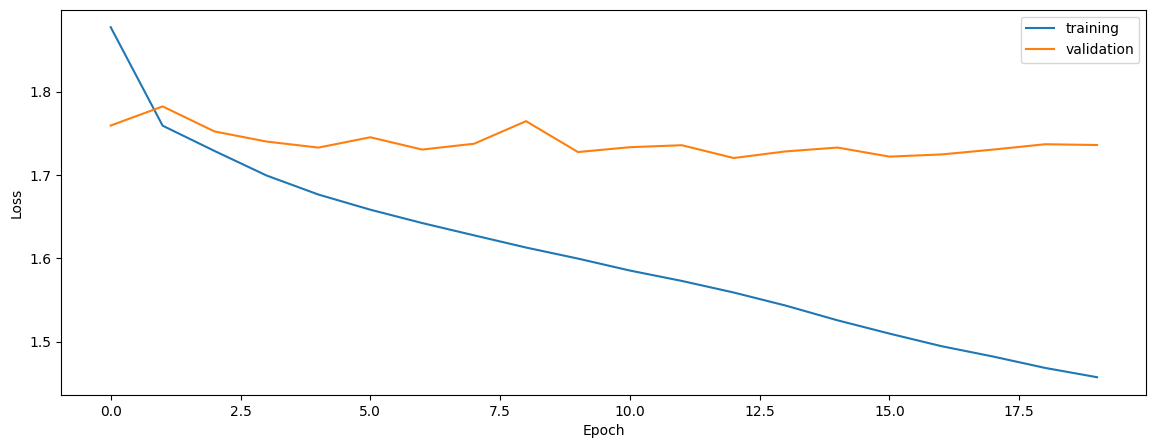

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.39427074423692
0.31629836922918386
0.33255027972296547


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('normalized')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

normalized
0.4312112251556172
0.39606708280657393
0.37075277081142305


In [9]:
print('native')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

native
0.43065514767685664
0.39660121868652676
0.3786521705434939


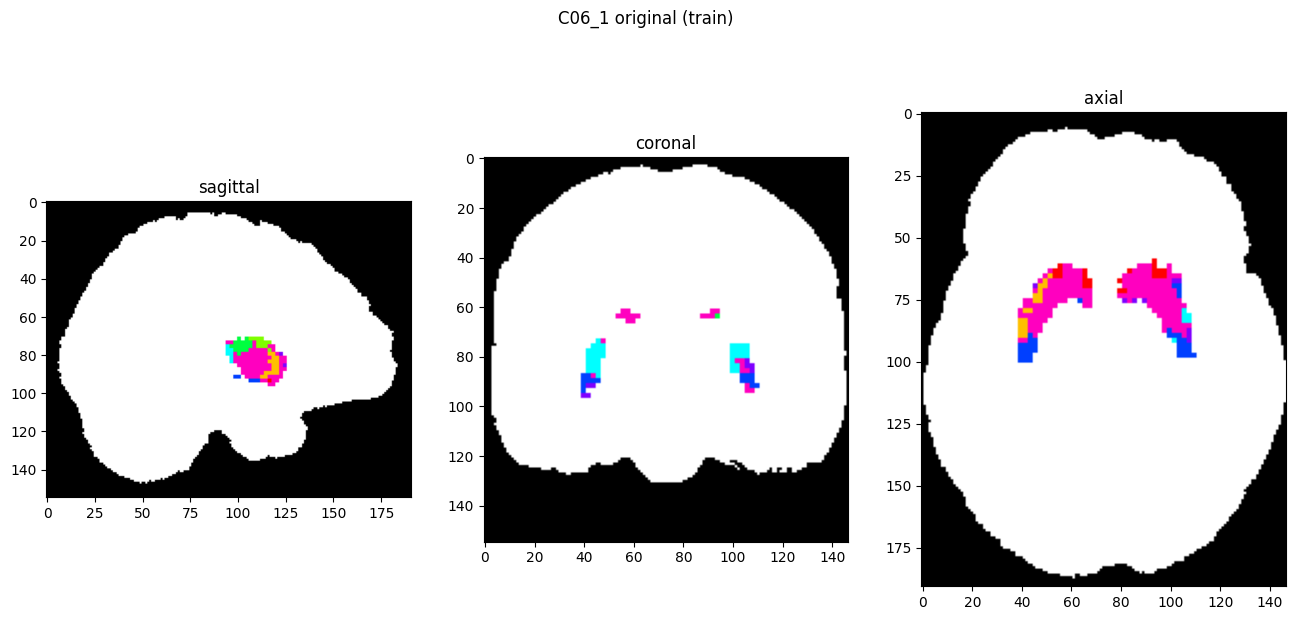

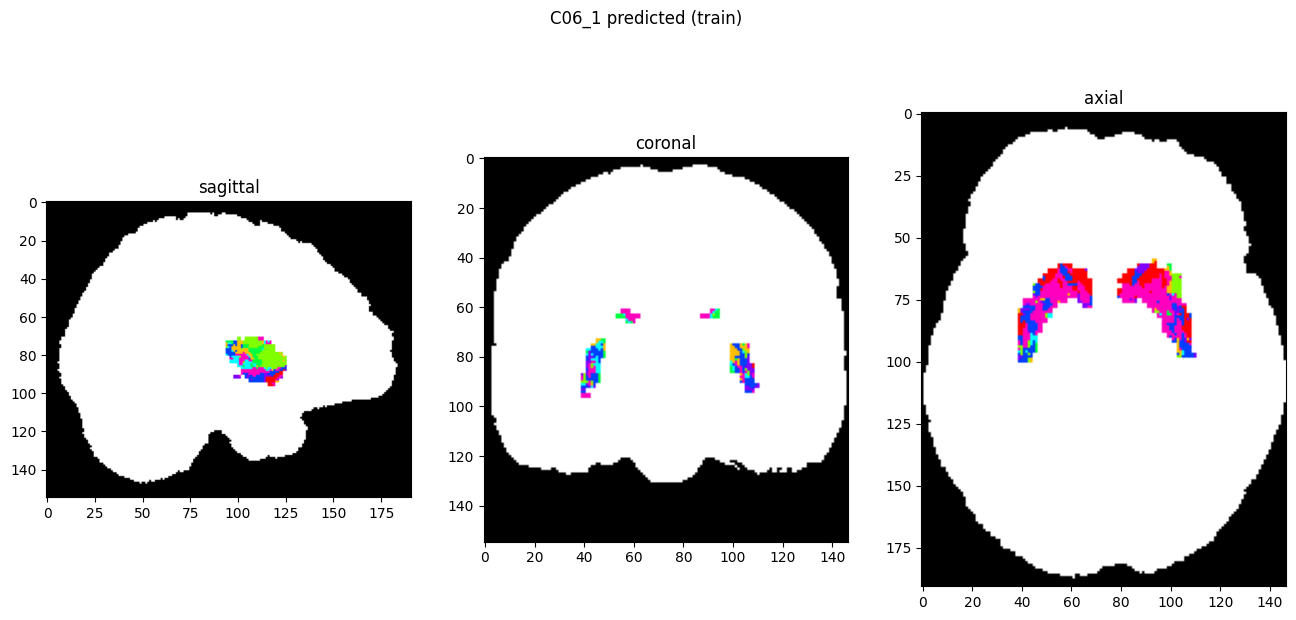

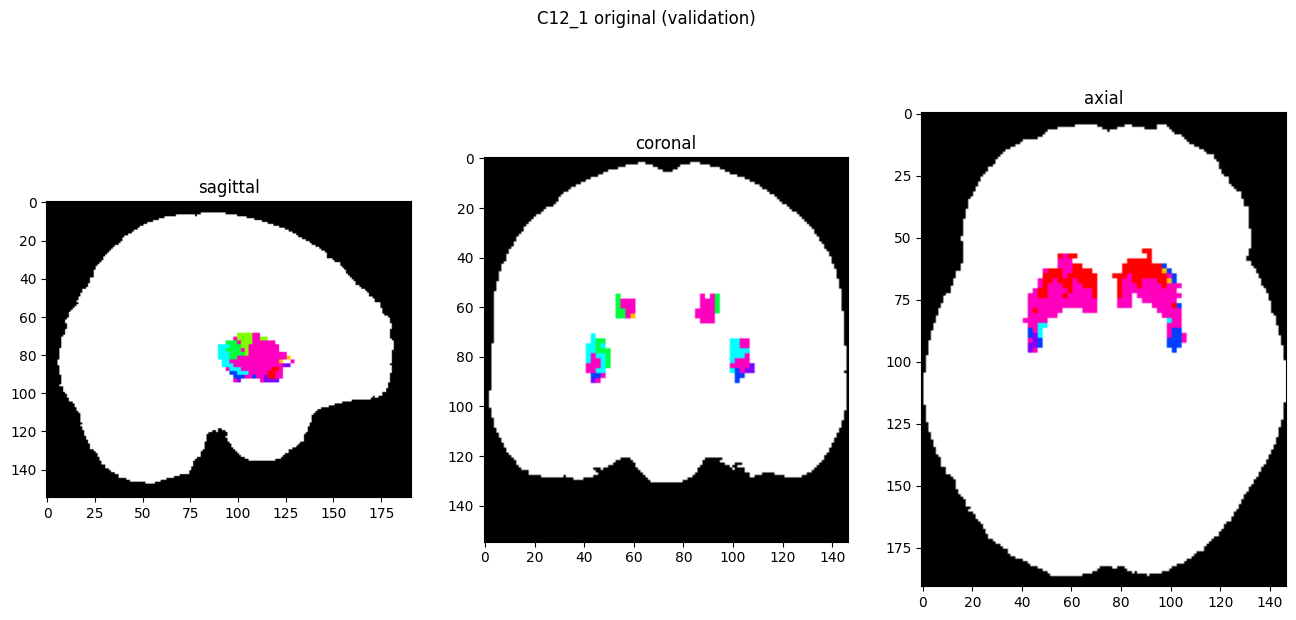

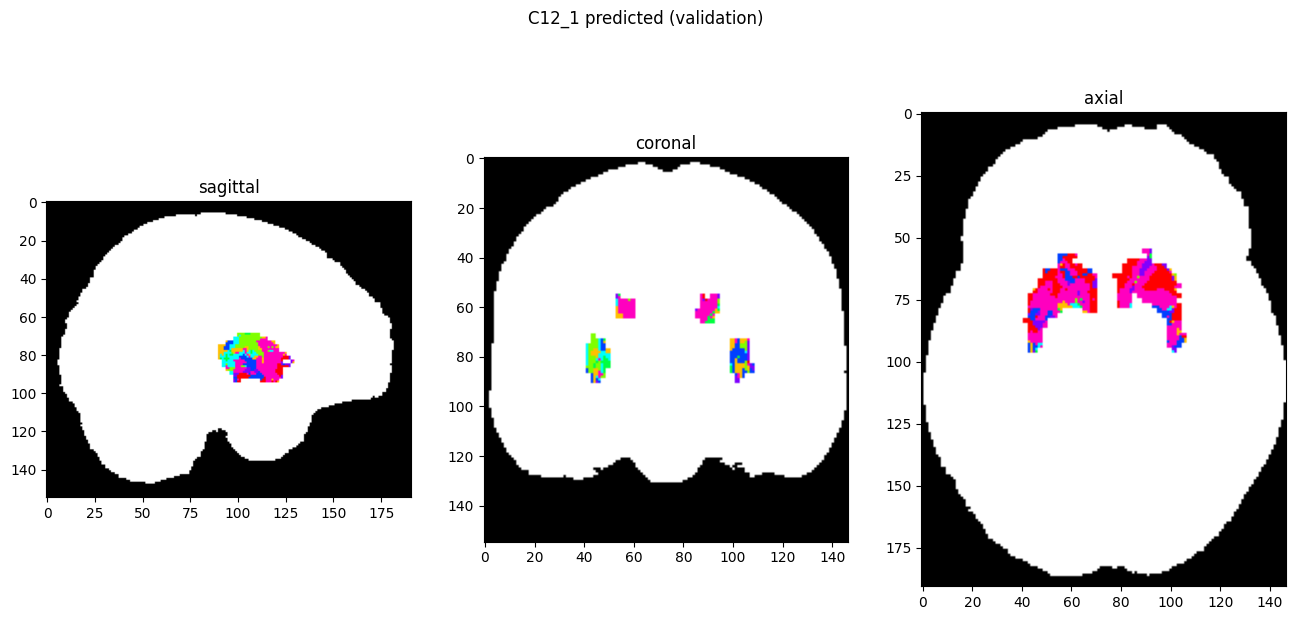

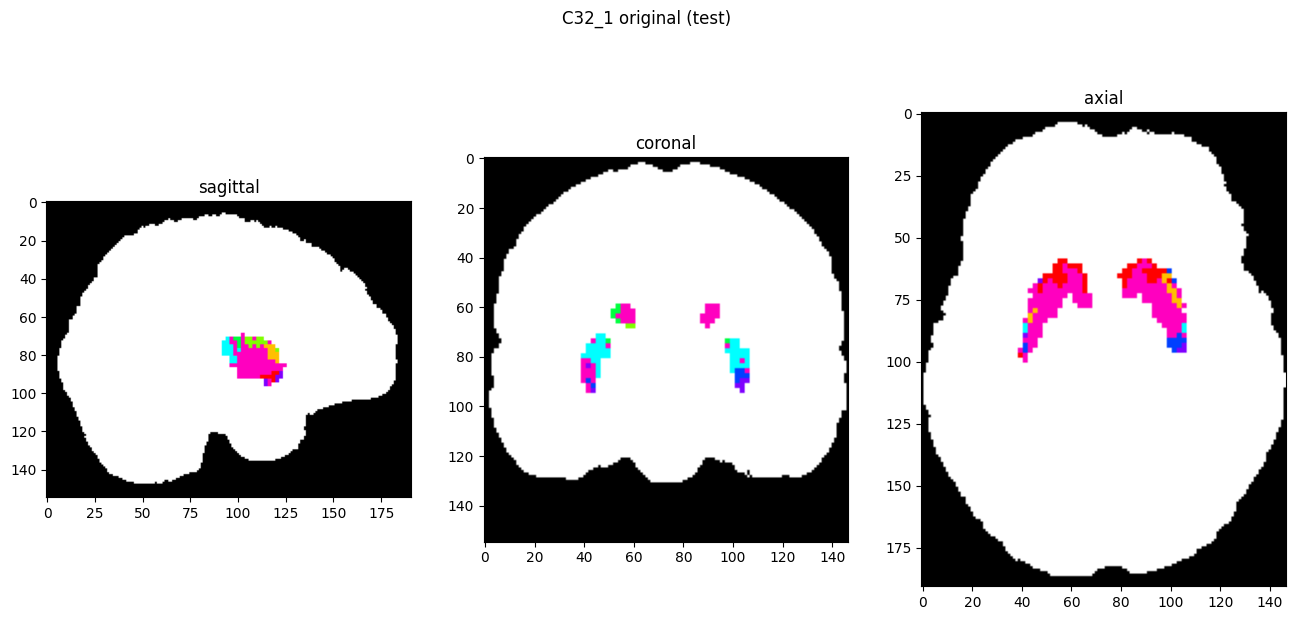

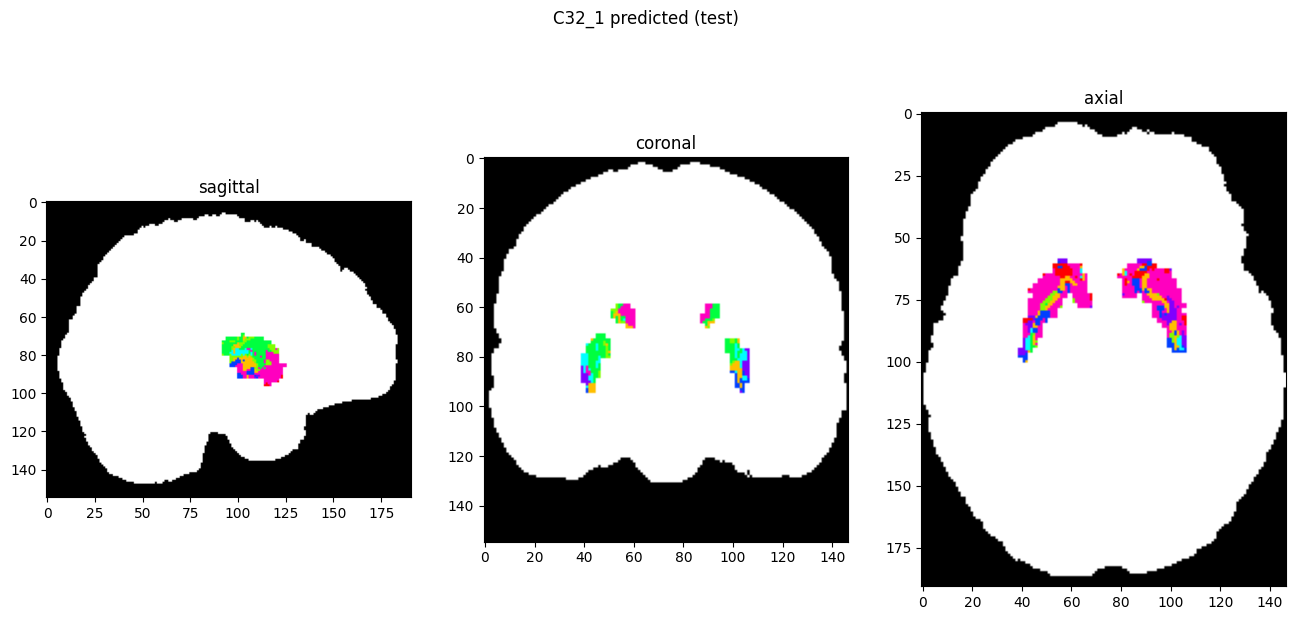

In [10]:
showResults(model, gen, threshold=0)